In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import math
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler
from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization

In [7]:
FF_df = pd.read_csv('form_factors.csv')
TD_x_df = pd.read_csv('gpr_total_density_x_200.csv')
TD_y_df = pd.read_csv('gpr_total_density_y_200.csv')

FF_df = FF_df.transpose()
TD_x_df = TD_x_df.transpose()
TD_y_df = TD_y_df.transpose()

FF_df = (FF_df-FF_df.mean())/FF_df.std()
TD_x_df = (TD_x_df-TD_x_df.mean())/TD_x_df.std()
TD_y_df = (TD_y_df-TD_y_df.mean())/TD_y_df.std()

In [3]:
def loss(actual,prediction):
    length = int(len(prediction[0])/2)
    
    index = 0
    distance_average_sum = 0
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        distance_average_sum = distance_average_sum + distance_sum/length
        index = index + 1
        
    return (distance_average_sum)/len(prediction)

def plots(actual,prediction):
    random.seed(42)
    train = random.sample(range(0,len(test_input_values)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x_1 = prediction[number][0:length]
        y_1 = prediction[number][length:]
        plt.plot(x_1,y_1,c='b')

        x_2 = test_output_values[number][0:length]
        y_2 = test_output_values[number][length:]
        plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random predictions |blue| against actual |red|')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b', label='Prediction', alpha=0.25)
        t_x = test_output_values[index][0:length].tolist()
        t_y = test_output_values[index][length:].tolist()
        plt.scatter(t_x,t_y,c='r', label = 'Actual', alpha=0.50)
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction |blue| and actual |red| data')
    plt.show()
    
    number = 6 # Number six is broken
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    
    number = 75
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    
    number = 80
    prediction = model.predict(test_input_values)
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of simulation ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show()
    
def training_loss(true, pred):
    row_length = int(tf.shape(true)[1]/2)
    column_length = int(tf.shape(true)[0])
    
    p_x = tf.cast(pred[:, 0:row_length], tf.float32)
    p_y = tf.cast(pred[:, row_length:], tf.float32)
    t_x = tf.cast(true[:, 0:row_length], tf.float32)
    t_y = tf.cast(true[:, row_length:], tf.float32)
    
    distance_squared = (t_x - p_x)**2 + (t_y - p_y)**2
    distance = tf.sqrt(distance_squared)
    distance_sum = tf.reduce_sum(distance, axis=-1)
    distance_average = tf.reduce_mean(distance_sum)
    
    return distance_average / tf.cast(tf.shape(true)[0], tf.float32)

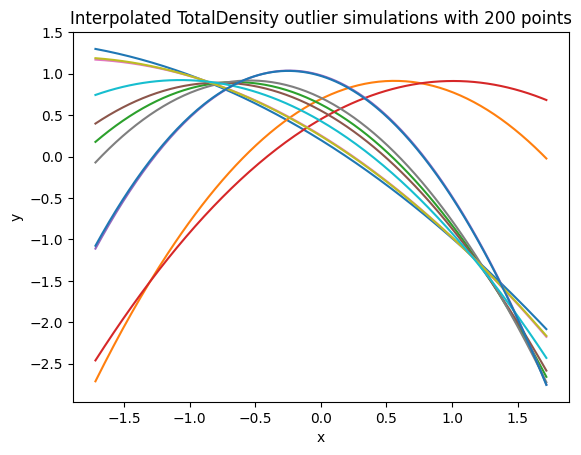

In [8]:
column_indexes = []
index = 0
for value in TD_y_df.iloc[99]:
    if value > -1:
        column_indexes.append(index)
    index = index + 1
    
for index in column_indexes:
    plt.plot(TD_x_df[index],TD_y_df[index])
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interpolated TotalDensity outlier simulations with 200 points')
plt.show()

In [9]:
FF_df = FF_df.drop(column_indexes, axis=1)
TD_x_df = TD_x_df.drop(column_indexes, axis=1)
TD_y_df = TD_y_df.drop(column_indexes, axis=1)

In [10]:
names = []
for i in TD_x_df.columns:
    names.append(str(i) + 'x')
    names.append(str(i) + 'y')

TD_df = pd.DataFrame(index=range(200),columns=[names])

for i in TD_x_df.columns:
    x_value = []
    y_value = []
    for value in TD_x_df[i]:
        x_value.append(value)
    for value in TD_y_df[i]:
        y_value.append(value)
    
    TD_df[str(i) + 'x'] = x_value
    TD_df[str(i) + 'y'] = y_value
    
TD_df

0x        0y        1x        1y        2x        2y        3x  \
0   -1.719098 -0.292967 -1.719098 -0.043943 -1.719098 -0.158113 -1.719098   
1   -1.701821 -0.287719 -1.701821 -0.048955 -1.701821 -0.158903 -1.701821   
2   -1.684543 -0.285331 -1.684543 -0.054403 -1.684543 -0.159960 -1.684543   
3   -1.667266 -0.284011 -1.667266 -0.057850 -1.667266 -0.160734 -1.667266   
4   -1.649989 -0.283050 -1.649989 -0.058699 -1.649989 -0.161087 -1.649989   
..        ...       ...       ...       ...       ...       ...       ...   
195  1.649989 -0.284641  1.649989 -0.058231  1.649989 -0.159933  1.649989   
196  1.667266 -0.285351  1.667266 -0.056702  1.667266 -0.158876  1.667266   
197  1.684543 -0.286225  1.684543 -0.055992  1.684543 -0.158280  1.684543   
198  1.701821 -0.288039  1.701821 -0.057726  1.701821 -0.159393  1.701821   
199  1.719098 -0.292285  1.719098 -0.064301  1.719098 -0.164136  1.719098   

           3y        4x        4y  ...      608x      608y      609x  \
0   -0.101767 -1.719098 -0.074313  ... -1.719098 -0.245502 -1.719098   
1   -0.108930 -1.701821 -0.065830  ... -1.701821 -0.245715 -1.701821   
2   -0.112849 -1.684543 -0.062805  ... -1.684543 -0.246071 -1.684543   
3   -0.114323 -1.667266 -0.062832  ... -1.667266 -0.246198 -1.667266   
4   -0.114178 -1.649989 -0.064223  ... -1.649989 -0.246001 -1.649989   
..        ...       ...       ...  ...       ...       ...       ...   
195 -0.114170  1.649989 -0.065815  ...  1.649989 -0.246660  1.649989   
196 -0.114536  1.667266 -0.064869  ...  1.667266 -0.246312  1.667266   
197 -0.115670  1.684543 -0.063731  ...  1.684543 -0.246020  1.684543   
198 -0.117792  1.701821 -0.063152  ...  1.701821 -0.246297  1.701821   
199 -0.121192  1.719098 -0.064547  ...  1.719098 -0.248100  1.719098   

         609y      610x      610y      611x      611y      612x      612y  
0   -0.061689 -1.719098 -0.065606 -1.719098 -0.220929 -1.719098 -0.171157  
1   -0.050817 -1.701821 -0.060005 -1.701821 -0.218079 -1.701821 -0.128594  
2   -0.053721 -1.684543 -0.057062 -1.684543 -0.216923 -1.684543 -0.104758  
3   -0.060734 -1.667266 -0.055632 -1.667266 -0.216739 -1.667266 -0.095096  
4   -0.066050 -1.649989 -0.055196 -1.649989 -0.216993 -1.649989 -0.095194  
..        ...       ...       ...       ...       ...       ...       ...  
195 -0.048337  1.649989 -0.057925  1.649989 -0.217384  1.649989 -0.111441  
196 -0.048564  1.667266 -0.064769  1.667266 -0.216985  1.667266 -0.107901  
197 -0.052194  1.684543 -0.069580  1.684543 -0.216915  1.684543 -0.105345  
198 -0.061096  1.701821 -0.068880  1.701821 -0.217690  1.701821 -0.105507  
199 -0.078233  1.719098 -0.059392  1.719098 -0.220034  1.719098 -0.110609  

[200 rows x 1204 columns]

In [11]:
input_data = FF_df.iloc[: , :-2]
output_data = TD_df.iloc[: , :-4]

In [8]:
input_data

0         1         2         3         4         5         6    \
0    0.980720 -0.444256  0.186761 -0.047851 -0.354703 -0.584007 -0.183981   
1    0.980030 -0.444704  0.186284 -0.048252 -0.355220 -0.584411 -0.183635   
2    0.977961 -0.446046  0.184852 -0.049453 -0.356769 -0.585624 -0.182598   
3    0.974512 -0.448282  0.182466 -0.051454 -0.359351 -0.587644 -0.180870   
4    0.969687 -0.451412  0.179127 -0.054255 -0.362964 -0.590472 -0.178453   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.637919 -0.763000 -0.775248 -0.745377 -0.664294 -0.757084 -0.752626   
996 -0.637355 -0.762537 -0.774302 -0.744959 -0.665308 -0.758153 -0.751415   
997 -0.636854 -0.762078 -0.773360 -0.744537 -0.666345 -0.759220 -0.750233   
998 -0.636415 -0.761626 -0.772425 -0.744112 -0.667403 -0.760285 -0.749080   
999 -0.636038 -0.761180 -0.771495 -0.743684 -0.668483 -0.761346 -0.747956   

          7         8         9    ...       601       602       603  \
0   -0.309006 -0.349255  0.267737  ... -0.670520 -0.250014 -0.513892   
1   -0.309460 -0.349860  0.267305  ... -0.670950 -0.250566 -0.514353   
2   -0.310820 -0.351675  0.266009  ... -0.672240 -0.252221 -0.515734   
3   -0.313086 -0.354698  0.263851  ... -0.674390 -0.254978 -0.518037   
4   -0.316257 -0.358928  0.260830  ... -0.677398 -0.258837 -0.521258   
..        ...       ...       ...  ...       ...       ...       ...   
995 -0.656961 -0.656225 -0.777161  ... -0.743381 -0.669381 -0.857844   
996 -0.656542 -0.659345 -0.777468  ... -0.743575 -0.669735 -0.857907   
997 -0.656158 -0.662494 -0.777772  ... -0.743771 -0.670089 -0.857928   
998 -0.655810 -0.665672 -0.778070  ... -0.743970 -0.670442 -0.857907   
999 -0.655498 -0.668877 -0.778360  ... -0.744172 -0.670794 -0.857847   

          604       605       606       607       608       609       610  
0   -0.299718 -0.477219  0.087297 -0.142115  0.840006 -0.459976 -0.427894  
1   -0.299953 -0.477644  0.086667 -0.142717  0.839384 -0.460461 -0.428323  
2   -0.300657 -0.478919  0.084776 -0.144520  0.837520 -0.461915 -0.429612  
3   -0.301829 -0.481043  0.081625 -0.147525  0.834413 -0.464338 -0.431758  
4   -0.303470 -0.484016  0.077216 -0.151730  0.830066 -0.467729 -0.434762  
..        ...       ...       ...       ...       ...       ...       ...  
995 -0.764482 -0.705293 -0.861659 -0.689449 -0.738946 -0.677948 -0.761120  
996 -0.765611 -0.704952 -0.862931 -0.690513 -0.738721 -0.677956 -0.760901  
997 -0.766756 -0.704615 -0.864157 -0.691557 -0.738505 -0.678050 -0.760640  
998 -0.767919 -0.704282 -0.865337 -0.692583 -0.738300 -0.678230 -0.760337  
999 -0.769097 -0.703954 -0.866470 -0.693590 -0.738105 -0.678494 -0.759994  

[1000 rows x 600 columns]

In [9]:
output_data

0x        0y        1x        1y        2x        2y        3x  \
0   -1.719098 -0.292967 -1.719098 -0.043943 -1.719098 -0.158113 -1.719098   
1   -1.701821 -0.287719 -1.701821 -0.048955 -1.701821 -0.158903 -1.701821   
2   -1.684543 -0.285331 -1.684543 -0.054403 -1.684543 -0.159960 -1.684543   
3   -1.667266 -0.284011 -1.667266 -0.057850 -1.667266 -0.160734 -1.667266   
4   -1.649989 -0.283050 -1.649989 -0.058699 -1.649989 -0.161087 -1.649989   
..        ...       ...       ...       ...       ...       ...       ...   
195  1.649989 -0.284641  1.649989 -0.058231  1.649989 -0.159933  1.649989   
196  1.667266 -0.285351  1.667266 -0.056702  1.667266 -0.158876  1.667266   
197  1.684543 -0.286225  1.684543 -0.055992  1.684543 -0.158280  1.684543   
198  1.701821 -0.288039  1.701821 -0.057726  1.701821 -0.159393  1.701821   
199  1.719098 -0.292285  1.719098 -0.064301  1.719098 -0.164136  1.719098   

           3y        4x        4y  ...      606x      606y      607x  \
0   -0.101767 -1.719098 -0.074313  ... -1.719098 -0.145616 -1.719098   
1   -0.108930 -1.701821 -0.065830  ... -1.701821 -0.147582 -1.701821   
2   -0.112849 -1.684543 -0.062805  ... -1.684543 -0.148528 -1.684543   
3   -0.114323 -1.667266 -0.062832  ... -1.667266 -0.147606 -1.667266   
4   -0.114178 -1.649989 -0.064223  ... -1.649989 -0.145384 -1.649989   
..        ...       ...       ...  ...       ...       ...       ...   
195 -0.114170  1.649989 -0.065815  ...  1.649989 -0.144443  1.649989   
196 -0.114536  1.667266 -0.064869  ...  1.667266 -0.143589  1.667266   
197 -0.115670  1.684543 -0.063731  ...  1.684543 -0.142992  1.684543   
198 -0.117792  1.701821 -0.063152  ...  1.701821 -0.144643  1.701821   
199 -0.121192  1.719098 -0.064547  ...  1.719098 -0.152251  1.719098   

         607y      608x      608y      609x      609y      610x      610y  
0   -0.091428 -1.719098 -0.245502 -1.719098 -0.061689 -1.719098 -0.065606  
1   -0.080542 -1.701821 -0.245715 -1.701821 -0.050817 -1.701821 -0.060005  
2   -0.080141 -1.684543 -0.246071 -1.684543 -0.053721 -1.684543 -0.057062  
3   -0.082219 -1.667266 -0.246198 -1.667266 -0.060734 -1.667266 -0.055632  
4   -0.083096 -1.649989 -0.246001 -1.649989 -0.066050 -1.649989 -0.055196  
..        ...       ...       ...       ...       ...       ...       ...  
195 -0.080849  1.649989 -0.246660  1.649989 -0.048337  1.649989 -0.057925  
196 -0.076135  1.667266 -0.246312  1.667266 -0.048564  1.667266 -0.064769  
197 -0.073838  1.684543 -0.246020  1.684543 -0.052194  1.684543 -0.069580  
198 -0.080083  1.701821 -0.246297  1.701821 -0.061096  1.701821 -0.068880  
199 -0.103521  1.719098 -0.248100  1.719098 -0.078233  1.719098 -0.059392  

[200 rows x 1200 columns]

In [12]:
column_index = []
for i in input_data.columns:
    column_index.append(i)

random.seed(42)
train = random.sample(column_index,488)
test = []
for number in column_index:
    if not number in train:
        test.append(number)

print(train)
print(test)

[119, 27, 286, 255, 233, 147, 109, 569, 94, 442, 34, 32, 100, 228, 243, 527, 29, 585, 208, 603, 439, 230, 469, 289, 6, 168, 601, 356, 587, 164, 225, 351, 604, 99, 398, 104, 375, 360, 275, 47, 480, 560, 132, 396, 84, 306, 378, 201, 74, 49, 238, 301, 85, 596, 108, 576, 582, 474, 381, 171, 388, 371, 219, 278, 76, 180, 607, 172, 483, 397, 281, 229, 339, 60, 239, 600, 330, 419, 279, 70, 221, 329, 222, 521, 414, 479, 151, 276, 605, 131, 390, 292, 280, 139, 391, 305, 224, 588, 304, 209, 190, 117, 73, 265, 257, 561, 395, 26, 450, 59, 81, 328, 558, 525, 583, 529, 312, 534, 202, 200, 493, 244, 572, 133, 288, 501, 5, 495, 377, 61, 357, 463, 531, 393, 141, 402, 335, 179, 536, 155, 227, 566, 237, 1, 481, 458, 376, 516, 261, 399, 96, 264, 57, 455, 327, 157, 440, 334, 464, 318, 106, 499, 196, 460, 86, 539, 407, 522, 0, 313, 170, 543, 9, 471, 509, 422, 162, 127, 31, 128, 295, 42, 46, 382, 253, 37, 555, 277, 401, 67, 68, 344, 248, 608, 88, 140, 487, 317, 494, 113, 444, 503, 552, 361, 107, 373, 581, 510

In [13]:
train_input_values = []
for number in train:
    train_input_values.append(input_data[number])
    
train_output_values = []
for number in train:
    list_1 = output_data[str(number) + 'x']
    list_2 = output_data[str(number) + 'y']
    train_output_values.append(np.concatenate((list_1,list_2)))

test_input_values = []
for number in test:
    test_input_values.append(input_data[number])
    
test_output_values = []
for number in test:
    list_1 = output_data[str(number) + 'x']
    list_2 = output_data[str(number) + 'y']
    test_output_values.append(np.concatenate((list_1,list_2)))
    
train_input_values = np.array(train_input_values).astype(np.float32)
train_output_values = np.array(train_output_values).astype(np.float32)
test_input_values = np.array(test_input_values).astype(np.float32)
test_output_values = np.array(test_output_values).astype(np.float32)

print(train_input_values.shape)
print(train_output_values.shape)
print(test_input_values.shape)
print(test_output_values.shape)

(488, 1000)
(488, 400, 1)
(112, 1000)
(112, 400, 1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 2000)              2002000   
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 1000)              2001000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              1001000   
                                                                 
 dropout_2 (Dropout)         (None, 1000)              0     

7/7 [==============================] - 2s 314ms/step - loss: 0.1236 - val_loss: 0.1421
Epoch 62/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.1235 - val_loss: 0.1418
Epoch 63/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.1240 - val_loss: 0.1405
Epoch 64/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1231 - val_loss: 0.1351
Epoch 65/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.1215 - val_loss: 0.1328
Epoch 66/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1206 - val_loss: 0.1435
Epoch 67/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1220 - val_loss: 0.1383
Epoch 68/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1208 - val_loss: 0.1429
Epoch 69/1500
7/7 [==============================] - 1s 161ms/step - loss: 0.1194 - val_loss: 0.1309
Epoch 70/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.1169 - val_loss: 0.1344
Epoc

Epoch 142/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0890 - val_loss: 0.1090
Epoch 143/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0887 - val_loss: 0.1125
Epoch 144/1500
7/7 [==============================] - 1s 114ms/step - loss: 0.0894 - val_loss: 0.1087
Epoch 145/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.0884 - val_loss: 0.1106
Epoch 146/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.0894 - val_loss: 0.1121
Epoch 147/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0930 - val_loss: 0.1160
Epoch 148/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0916 - val_loss: 0.1102
Epoch 149/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0896 - val_loss: 0.1114
Epoch 150/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0905 - val_loss: 0.1107
Epoch 151/1500
7/7 [==============================] - 2s 377ms/step - loss: 0.0898

7/7 [==============================] - 2s 279ms/step - loss: 0.0680 - val_loss: 0.0969
Epoch 303/1500
7/7 [==============================] - 4s 594ms/step - loss: 0.0663 - val_loss: 0.1004
Epoch 304/1500
7/7 [==============================] - 5s 813ms/step - loss: 0.0666 - val_loss: 0.1034
Epoch 305/1500
7/7 [==============================] - 2s 234ms/step - loss: 0.0619 - val_loss: 0.1016
Epoch 306/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0644 - val_loss: 0.1013
Epoch 307/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0683 - val_loss: 0.1021
Epoch 308/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0654 - val_loss: 0.1007
Epoch 309/1500
7/7 [==============================] - 2s 292ms/step - loss: 0.0653 - val_loss: 0.1064
Epoch 310/1500
7/7 [==============================] - 2s 323ms/step - loss: 0.0670 - val_loss: 0.1007
Epoch 311/1500
7/7 [==============================] - 5s 854ms/step - loss: 0.0663 - val_loss: 0.

7/7 [==============================] - 3s 553ms/step - loss: 0.0472 - val_loss: 0.0935
Epoch 463/1500
7/7 [==============================] - 3s 515ms/step - loss: 0.0462 - val_loss: 0.0979
Epoch 464/1500
7/7 [==============================] - 2s 369ms/step - loss: 0.0461 - val_loss: 0.0951
Epoch 465/1500
7/7 [==============================] - 3s 506ms/step - loss: 0.0483 - val_loss: 0.0989
Epoch 466/1500
7/7 [==============================] - 3s 532ms/step - loss: 0.0506 - val_loss: 0.0992
Epoch 467/1500
7/7 [==============================] - 3s 526ms/step - loss: 0.0505 - val_loss: 0.1031
Epoch 468/1500
7/7 [==============================] - 4s 678ms/step - loss: 0.0486 - val_loss: 0.0994
Epoch 469/1500
7/7 [==============================] - 3s 547ms/step - loss: 0.0438 - val_loss: 0.0997
Epoch 470/1500
7/7 [==============================] - 3s 515ms/step - loss: 0.0471 - val_loss: 0.0963
Epoch 471/1500
7/7 [==============================] - 6s 938ms/step - loss: 0.0485 - val_loss: 0.

7/7 [==============================] - 1s 130ms/step - loss: 0.0391 - val_loss: 0.1002
Epoch 623/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.0423 - val_loss: 0.1021
Epoch 624/1500
7/7 [==============================] - 1s 130ms/step - loss: 0.0420 - val_loss: 0.0954
Epoch 625/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.0429 - val_loss: 0.0972
Epoch 626/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.0414 - val_loss: 0.0972
Epoch 627/1500
7/7 [==============================] - 1s 131ms/step - loss: 0.0463 - val_loss: 0.0940
Epoch 628/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.0423 - val_loss: 0.0919
Epoch 629/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.0459 - val_loss: 0.0911
Epoch 630/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.0387 - val_loss: 0.0956
Epoch 631/1500
7/7 [==============================] - 4s 731ms/step - loss: 0.0390 - val_loss: 0.

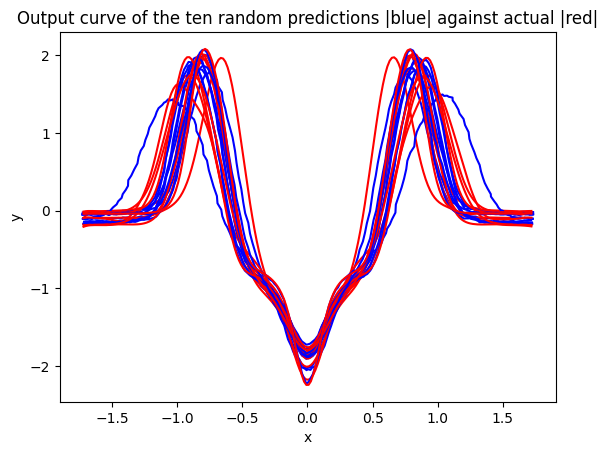

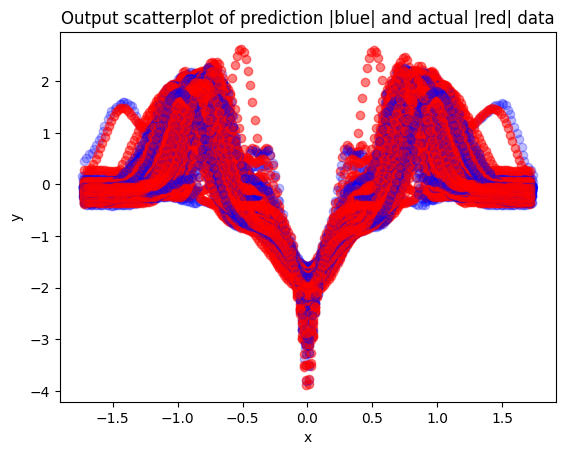

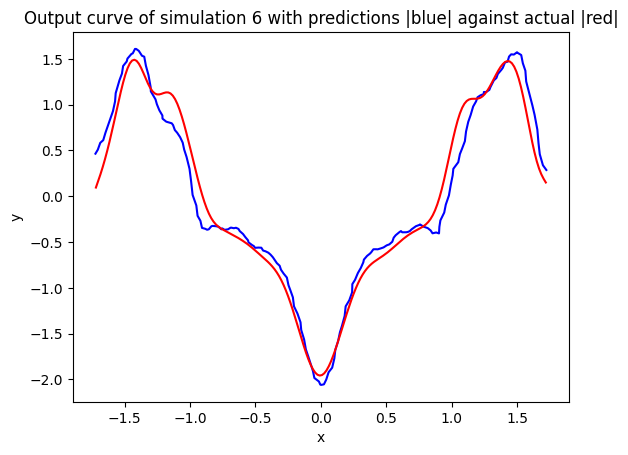

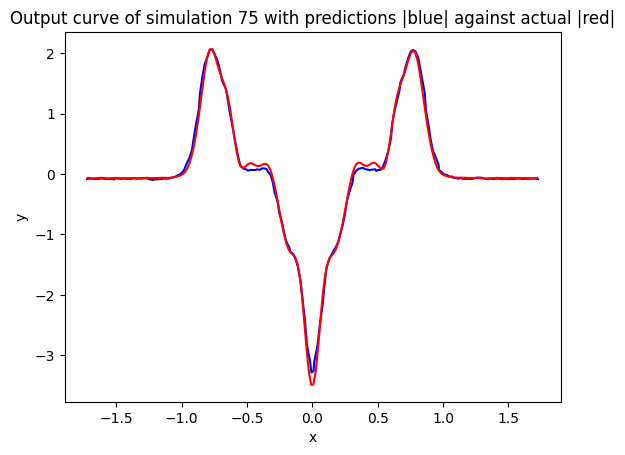

4/4 [==============================] - 0s 9ms/step


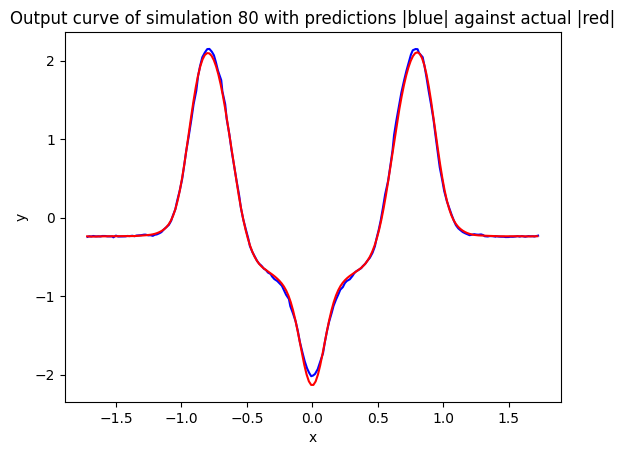

In [10]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_5_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 2000)              2002000   
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 1000)              2001000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              1001000   
                                                                 
 dropout_2 (Dropout)         (None, 1000)              0     

7/7 [==============================] - 2s 359ms/step - loss: 0.1214 - val_loss: 0.1398
Epoch 62/1500
7/7 [==============================] - 1s 130ms/step - loss: 0.1242 - val_loss: 0.1366
Epoch 63/1500
7/7 [==============================] - 1s 207ms/step - loss: 0.1209 - val_loss: 0.1364
Epoch 64/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1202 - val_loss: 0.1343
Epoch 65/1500
7/7 [==============================] - 1s 143ms/step - loss: 0.1182 - val_loss: 0.1345
Epoch 66/1500
7/7 [==============================] - 1s 145ms/step - loss: 0.1178 - val_loss: 0.1332
Epoch 67/1500
7/7 [==============================] - 1s 166ms/step - loss: 0.1189 - val_loss: 0.1368
Epoch 68/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1164 - val_loss: 0.1349
Epoch 69/1500
7/7 [==============================] - 1s 148ms/step - loss: 0.1161 - val_loss: 0.1299
Epoch 70/1500
7/7 [==============================] - 1s 212ms/step - loss: 0.1157 - val_loss: 0.1316
Epoc

Epoch 142/1500
7/7 [==============================] - 1s 168ms/step - loss: 0.0885 - val_loss: 0.1124
Epoch 143/1500
7/7 [==============================] - 1s 232ms/step - loss: 0.0921 - val_loss: 0.1149
Epoch 144/1500
7/7 [==============================] - 1s 217ms/step - loss: 0.0961 - val_loss: 0.1126
Epoch 145/1500
7/7 [==============================] - 2s 326ms/step - loss: 0.0906 - val_loss: 0.1164
Epoch 146/1500
7/7 [==============================] - 2s 289ms/step - loss: 0.0902 - val_loss: 0.1121
Epoch 147/1500
7/7 [==============================] - 2s 308ms/step - loss: 0.0883 - val_loss: 0.1095
Epoch 148/1500
7/7 [==============================] - 1s 139ms/step - loss: 0.0862 - val_loss: 0.1074
Epoch 149/1500
7/7 [==============================] - 1s 145ms/step - loss: 0.0896 - val_loss: 0.1153
Epoch 150/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0909 - val_loss: 0.1104
Epoch 151/1500
7/7 [==============================] - 3s 415ms/step - loss: 0.0869

7/7 [==============================] - 1s 120ms/step - loss: 0.0626 - val_loss: 0.1048
Epoch 303/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0645 - val_loss: 0.1064
Epoch 304/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0685 - val_loss: 0.1030
Epoch 305/1500
7/7 [==============================] - 2s 284ms/step - loss: 0.0676 - val_loss: 0.1039
Epoch 306/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0669 - val_loss: 0.1033
Epoch 307/1500
7/7 [==============================] - 2s 317ms/step - loss: 0.0634 - val_loss: 0.0975
Epoch 308/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0670 - val_loss: 0.1018
Epoch 309/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0638 - val_loss: 0.0979
Epoch 310/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0626 - val_loss: 0.0939
Epoch 311/1500
7/7 [==============================] - 2s 308ms/step - loss: 0.0619 - val_loss: 0.

7/7 [==============================] - 1s 114ms/step - loss: 0.0507 - val_loss: 0.0992
Epoch 463/1500
7/7 [==============================] - 1s 192ms/step - loss: 0.0463 - val_loss: 0.0999
Epoch 464/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0473 - val_loss: 0.0958
Epoch 465/1500
7/7 [==============================] - 1s 113ms/step - loss: 0.0472 - val_loss: 0.0964
Epoch 466/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0459 - val_loss: 0.0927
Epoch 467/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0467 - val_loss: 0.1000
Epoch 468/1500
7/7 [==============================] - 1s 114ms/step - loss: 0.0453 - val_loss: 0.0968
Epoch 469/1500
7/7 [==============================] - 2s 243ms/step - loss: 0.0458 - val_loss: 0.0993
Epoch 470/1500
7/7 [==============================] - 1s 114ms/step - loss: 0.0489 - val_loss: 0.0978
Epoch 471/1500
7/7 [==============================] - 2s 303ms/step - loss: 0.0459 - val_loss: 0.

7/7 [==============================] - 1s 114ms/step - loss: 0.0375 - val_loss: 0.0961
Epoch 623/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0375 - val_loss: 0.1023
Epoch 624/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0373 - val_loss: 0.0975
Epoch 625/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.0385 - val_loss: 0.0902
Epoch 626/1500
7/7 [==============================] - 1s 114ms/step - loss: 0.0375 - val_loss: 0.1000
Epoch 627/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.0374 - val_loss: 0.0962
Epoch 628/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0386 - val_loss: 0.0963
Epoch 629/1500
7/7 [==============================] - 1s 114ms/step - loss: 0.0387 - val_loss: 0.0997
Epoch 630/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.0436 - val_loss: 0.0966
Epoch 631/1500
7/7 [==============================] - 2s 308ms/step - loss: 0.0438 - val_loss: 0.

7/7 [==============================] - 1s 116ms/step - loss: 0.0340 - val_loss: 0.1030
Epoch 783/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0339 - val_loss: 0.1044
Epoch 784/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0327 - val_loss: 0.1017
Epoch 785/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0338 - val_loss: 0.0988
Epoch 786/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0322 - val_loss: 0.1037
Epoch 787/1500
7/7 [==============================] - 2s 268ms/step - loss: 0.0304 - val_loss: 0.1020
Epoch 788/1500
7/7 [==============================] - 1s 114ms/step - loss: 0.0334 - val_loss: 0.0942
Epoch 789/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0414 - val_loss: 0.0991
Epoch 790/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.0357 - val_loss: 0.1034
Epoch 791/1500
7/7 [==============================] - 2s 297ms/step - loss: 0.0363 - val_loss: 0.

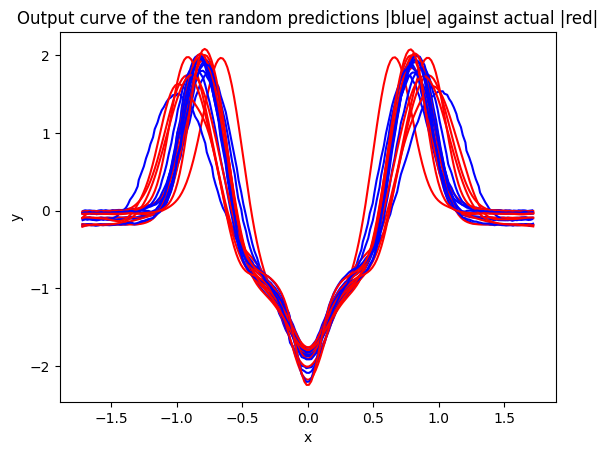

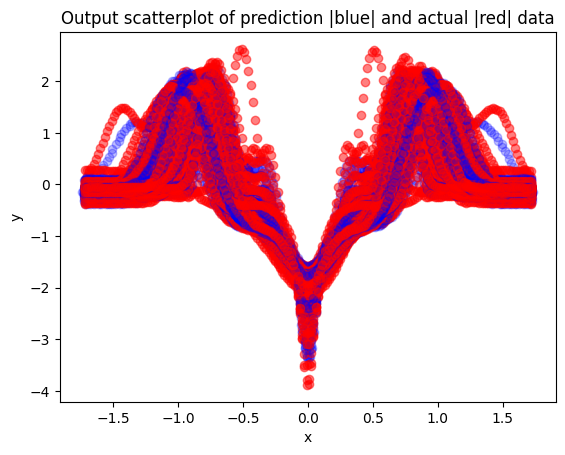

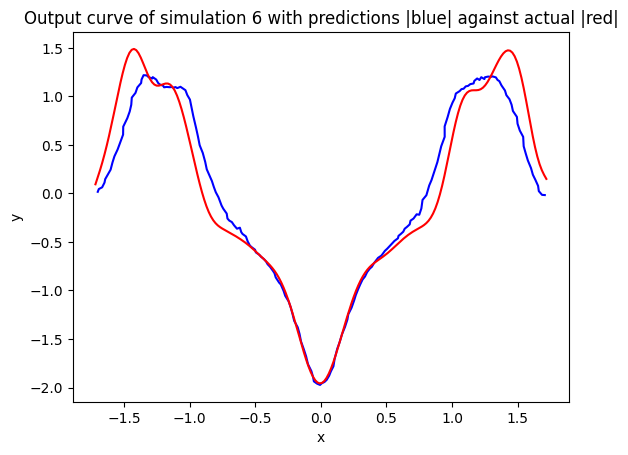

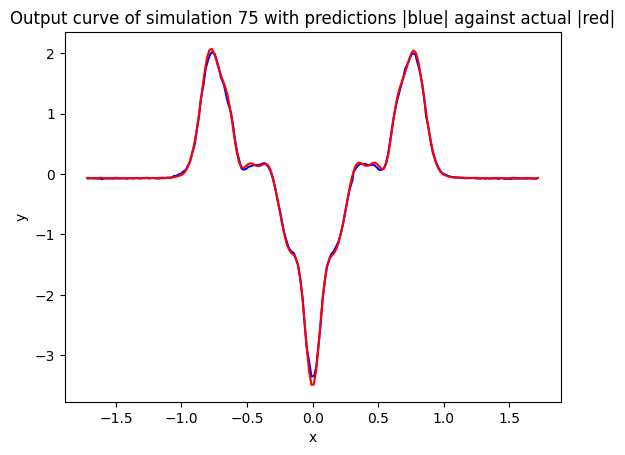

4/4 [==============================] - 0s 9ms/step


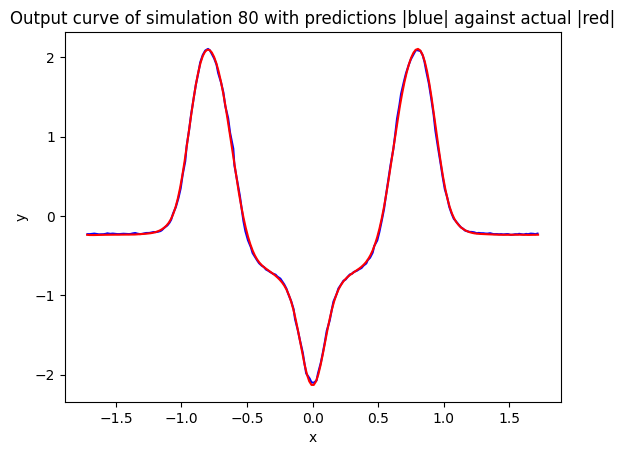

In [12]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_5_data',
                         histogram_freq=10,
                         write_graph=True,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_9 (Dense)             (None, 2000)              2002000   
                                                                 
 dropout_6 (Dropout)         (None, 2000)              0         
                                                                 
 dense_10 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_7 (Dropout)         (None, 1000)              0         
                                                                 
 dense_11 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_8 (Dropout)         (None, 1000)              0   

7/7 [==============================] - 2s 330ms/step - loss: 0.1256 - val_loss: 0.1423
Epoch 62/1500
7/7 [==============================] - 1s 157ms/step - loss: 0.1265 - val_loss: 0.1361
Epoch 63/1500
7/7 [==============================] - 1s 159ms/step - loss: 0.1265 - val_loss: 0.1398
Epoch 64/1500
7/7 [==============================] - 1s 189ms/step - loss: 0.1285 - val_loss: 0.1387
Epoch 65/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1244 - val_loss: 0.1378
Epoch 66/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1266 - val_loss: 0.1393
Epoch 67/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1236 - val_loss: 0.1366
Epoch 68/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1222 - val_loss: 0.1356
Epoch 69/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.1216 - val_loss: 0.1410
Epoch 70/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.1232 - val_loss: 0.1364
Epoc

Epoch 142/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1037 - val_loss: 0.1264
Epoch 143/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1034 - val_loss: 0.1195
Epoch 144/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0980 - val_loss: 0.1201
Epoch 145/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0989 - val_loss: 0.1193
Epoch 146/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1015 - val_loss: 0.1236
Epoch 147/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0997 - val_loss: 0.1226
Epoch 148/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0996 - val_loss: 0.1201
Epoch 149/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0993 - val_loss: 0.1238
Epoch 150/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1008 - val_loss: 0.1230
Epoch 151/1500
7/7 [==============================] - 2s 302ms/step - loss: 0.0965

7/7 [==============================] - 1s 127ms/step - loss: 0.0770 - val_loss: 0.1079
Epoch 303/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0772 - val_loss: 0.1163
Epoch 304/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0772 - val_loss: 0.1079
Epoch 305/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0825 - val_loss: 0.1110
Epoch 306/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0806 - val_loss: 0.1138
Epoch 307/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0777 - val_loss: 0.1071
Epoch 308/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0797 - val_loss: 0.1081
Epoch 309/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0758 - val_loss: 0.1116
Epoch 310/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.0754 - val_loss: 0.1096
Epoch 311/1500
7/7 [==============================] - 2s 307ms/step - loss: 0.0789 - val_loss: 0.

7/7 [==============================] - 1s 119ms/step - loss: 0.0613 - val_loss: 0.1067
Epoch 463/1500
7/7 [==============================] - 1s 151ms/step - loss: 0.0591 - val_loss: 0.1109
Epoch 464/1500
7/7 [==============================] - 1s 158ms/step - loss: 0.0618 - val_loss: 0.1067
Epoch 465/1500
7/7 [==============================] - 1s 228ms/step - loss: 0.0666 - val_loss: 0.1042
Epoch 466/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0688 - val_loss: 0.1011
Epoch 467/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0607 - val_loss: 0.1097
Epoch 468/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0619 - val_loss: 0.1058
Epoch 469/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0612 - val_loss: 0.1036
Epoch 470/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0564 - val_loss: 0.1053
Epoch 471/1500
7/7 [==============================] - 2s 306ms/step - loss: 0.0603 - val_loss: 0.

7/7 [==============================] - 1s 121ms/step - loss: 0.0526 - val_loss: 0.1028
Epoch 623/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0550 - val_loss: 0.1010
Epoch 624/1500
7/7 [==============================] - 1s 131ms/step - loss: 0.0516 - val_loss: 0.1023
Epoch 625/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.0540 - val_loss: 0.0989
Epoch 626/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0551 - val_loss: 0.1028
Epoch 627/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0558 - val_loss: 0.1001
Epoch 628/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0544 - val_loss: 0.0999
Epoch 629/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0525 - val_loss: 0.1041
Epoch 630/1500
7/7 [==============================] - 2s 272ms/step - loss: 0.0509 - val_loss: 0.1058
Epoch 631/1500
7/7 [==============================] - 2s 359ms/step - loss: 0.0543 - val_loss: 0.

7/7 [==============================] - 1s 123ms/step - loss: 0.0513 - val_loss: 0.1039
Epoch 783/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0537 - val_loss: 0.1103
Epoch 784/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0547 - val_loss: 0.1083
Epoch 785/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0507 - val_loss: 0.1011
Epoch 786/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0474 - val_loss: 0.1009
Epoch 787/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0480 - val_loss: 0.1030
Epoch 788/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0520 - val_loss: 0.1013
Epoch 789/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0482 - val_loss: 0.1009
Epoch 790/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0490 - val_loss: 0.1055
Epoch 791/1500
7/7 [==============================] - 2s 308ms/step - loss: 0.0499 - val_loss: 0.

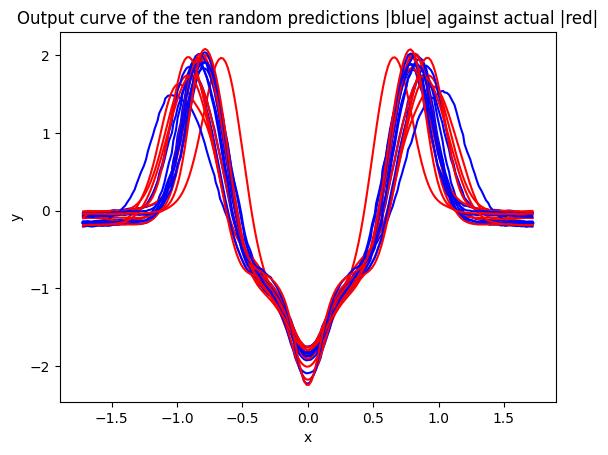

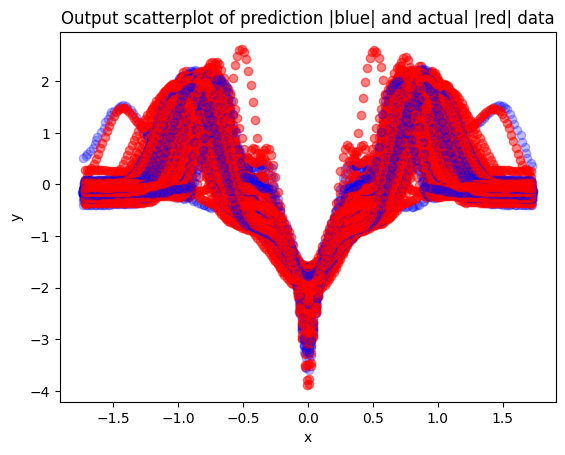

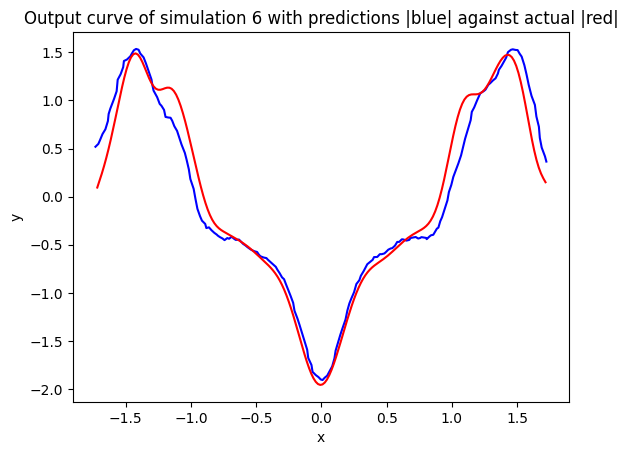

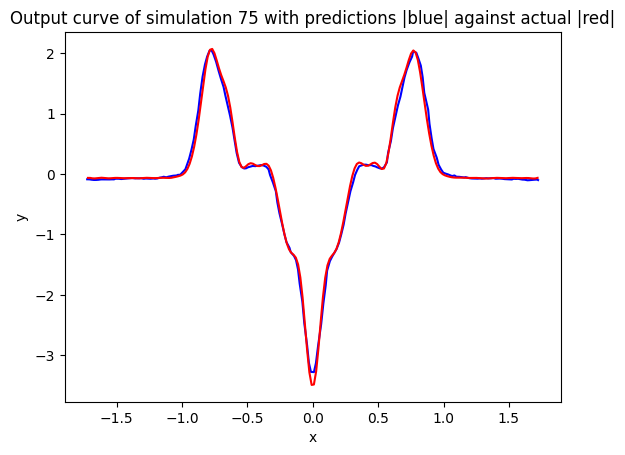

4/4 [==============================] - 0s 9ms/step


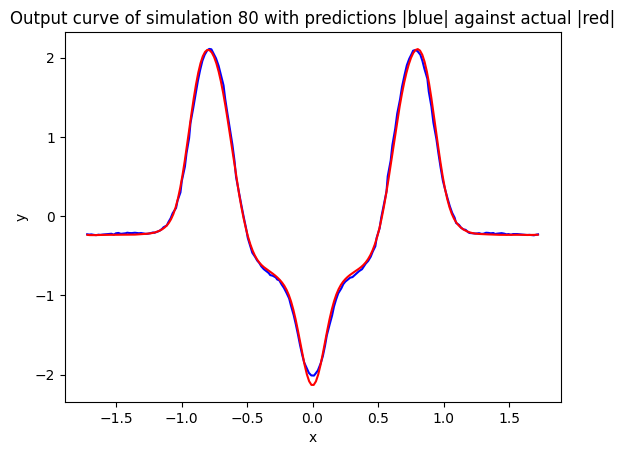

In [15]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", activity_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", activity_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", activity_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", activity_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_5_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_16 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_11 (Dropout)        (None, 2000)              0         
                                                                 
 dense_17 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_12 (Dropout)        (None, 1000)              0         
                                                                 
 dense_18 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_13 (Dropout)        (None, 1000)              0   

7/7 [==============================] - 2s 333ms/step - loss: 0.1316 - val_loss: 0.1598
Epoch 62/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1312 - val_loss: 0.1672
Epoch 63/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1305 - val_loss: 0.1533
Epoch 64/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.1303 - val_loss: 0.1583
Epoch 65/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.1296 - val_loss: 0.1404
Epoch 66/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.1325 - val_loss: 0.1599
Epoch 67/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1341 - val_loss: 0.1614
Epoch 68/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1308 - val_loss: 0.1348
Epoch 69/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1301 - val_loss: 0.1501
Epoch 70/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1257 - val_loss: 0.1433
Epoc

Epoch 142/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0984 - val_loss: 0.1107
Epoch 143/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0947 - val_loss: 0.1171
Epoch 144/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0940 - val_loss: 0.1106
Epoch 145/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0954 - val_loss: 0.1134
Epoch 146/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0946 - val_loss: 0.1122
Epoch 147/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0947 - val_loss: 0.1152
Epoch 148/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0963 - val_loss: 0.1154
Epoch 149/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0953 - val_loss: 0.1107
Epoch 150/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0925 - val_loss: 0.1208
Epoch 151/1500
7/7 [==============================] - 2s 319ms/step - loss: 0.0952

7/7 [==============================] - 1s 123ms/step - loss: 0.0720 - val_loss: 0.1100
Epoch 303/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0687 - val_loss: 0.1059
Epoch 304/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0703 - val_loss: 0.0970
Epoch 305/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0690 - val_loss: 0.0985
Epoch 306/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0682 - val_loss: 0.0983
Epoch 307/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0670 - val_loss: 0.1049
Epoch 308/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0716 - val_loss: 0.1018
Epoch 309/1500
7/7 [==============================] - 1s 117ms/step - loss: 0.0688 - val_loss: 0.1014
Epoch 310/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0696 - val_loss: 0.1018
Epoch 311/1500
7/7 [==============================] - 2s 310ms/step - loss: 0.0685 - val_loss: 0.

7/7 [==============================] - 1s 123ms/step - loss: 0.0578 - val_loss: 0.0981
Epoch 463/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0551 - val_loss: 0.0993
Epoch 464/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0577 - val_loss: 0.0958
Epoch 465/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0538 - val_loss: 0.0974
Epoch 466/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0541 - val_loss: 0.0981
Epoch 467/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0553 - val_loss: 0.1048
Epoch 468/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0549 - val_loss: 0.1045
Epoch 469/1500
7/7 [==============================] - 1s 116ms/step - loss: 0.0539 - val_loss: 0.1000
Epoch 470/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0556 - val_loss: 0.0986
Epoch 471/1500
7/7 [==============================] - 2s 302ms/step - loss: 0.0542 - val_loss: 0.

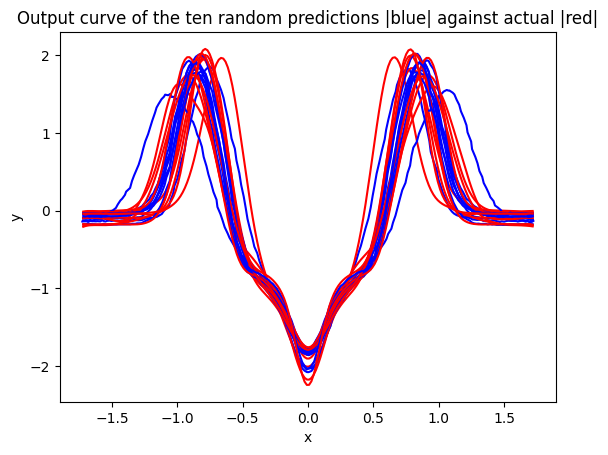

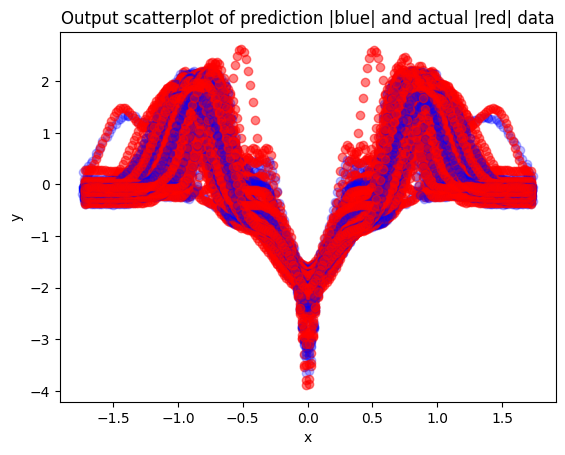

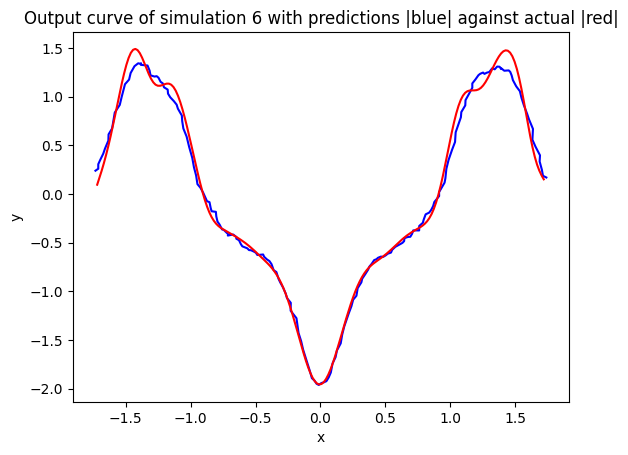

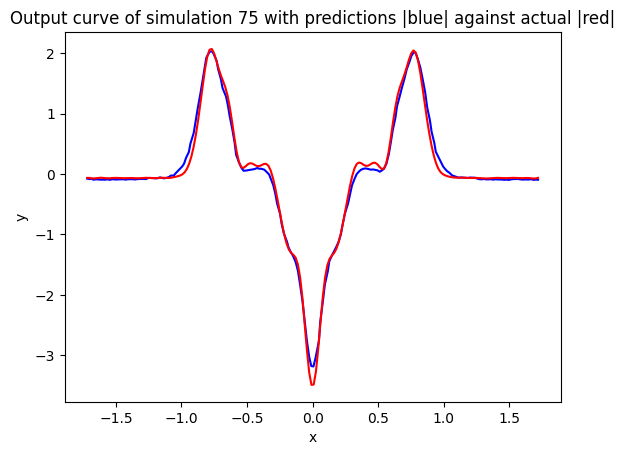

4/4 [==============================] - 0s 10ms/step


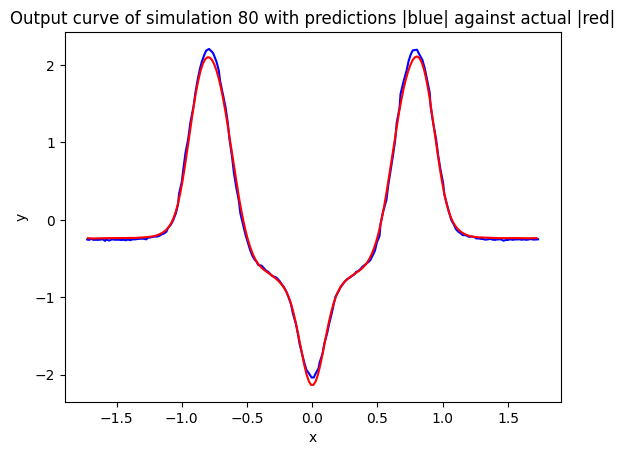

In [16]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_5_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_23 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_16 (Dropout)        (None, 2000)              0         
                                                                 
 dense_24 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_17 (Dropout)        (None, 1000)              0         
                                                                 
 dense_25 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_18 (Dropout)        (None, 1000)              0   

7/7 [==============================] - 2s 334ms/step - loss: 0.1485 - val_loss: 0.2070
Epoch 62/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1434 - val_loss: 0.2237
Epoch 63/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1422 - val_loss: 0.2292
Epoch 64/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.1472 - val_loss: 0.2272
Epoch 65/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.1451 - val_loss: 0.1932
Epoch 66/1500
7/7 [==============================] - 1s 129ms/step - loss: 0.1427 - val_loss: 0.2248
Epoch 67/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1447 - val_loss: 0.2307
Epoch 68/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1493 - val_loss: 0.1740
Epoch 69/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1530 - val_loss: 0.1611
Epoch 70/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1403 - val_loss: 0.2139
Epoc

Epoch 142/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1109 - val_loss: 0.1486
Epoch 143/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.1118 - val_loss: 0.1440
Epoch 144/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1130 - val_loss: 0.1363
Epoch 145/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.1101 - val_loss: 0.1392
Epoch 146/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.1103 - val_loss: 0.1323
Epoch 147/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.1091 - val_loss: 0.1285
Epoch 148/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.1104 - val_loss: 0.1364
Epoch 149/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1083 - val_loss: 0.1402
Epoch 150/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1095 - val_loss: 0.1243
Epoch 151/1500
7/7 [==============================] - 2s 311ms/step - loss: 0.1119

7/7 [==============================] - 1s 119ms/step - loss: 0.0880 - val_loss: 0.1045
Epoch 303/1500
7/7 [==============================] - 1s 166ms/step - loss: 0.0865 - val_loss: 0.1052
Epoch 304/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0869 - val_loss: 0.1054
Epoch 305/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0865 - val_loss: 0.1062
Epoch 306/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0843 - val_loss: 0.1065
Epoch 307/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0864 - val_loss: 0.1085
Epoch 308/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.0857 - val_loss: 0.1053
Epoch 309/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0861 - val_loss: 0.1076
Epoch 310/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0860 - val_loss: 0.1083
Epoch 311/1500
7/7 [==============================] - 2s 304ms/step - loss: 0.0838 - val_loss: 0.

7/7 [==============================] - 1s 120ms/step - loss: 0.0695 - val_loss: 0.1036
Epoch 463/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0711 - val_loss: 0.1034
Epoch 464/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.0700 - val_loss: 0.1004
Epoch 465/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0715 - val_loss: 0.1027
Epoch 466/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0756 - val_loss: 0.1025
Epoch 467/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0707 - val_loss: 0.0986
Epoch 468/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0710 - val_loss: 0.1081
Epoch 469/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0750 - val_loss: 0.1117
Epoch 470/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0744 - val_loss: 0.1106
Epoch 471/1500
7/7 [==============================] - 2s 306ms/step - loss: 0.0775 - val_loss: 0.

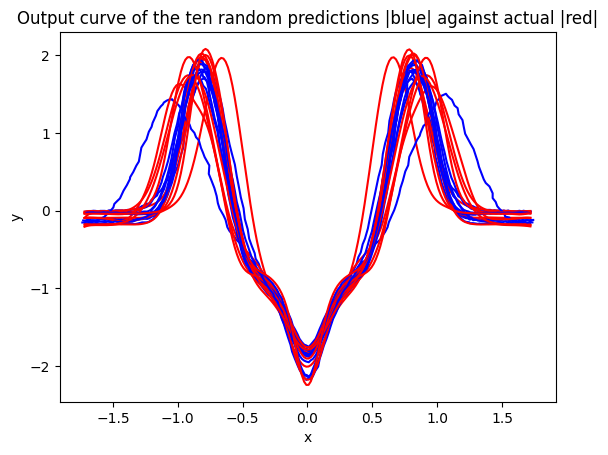

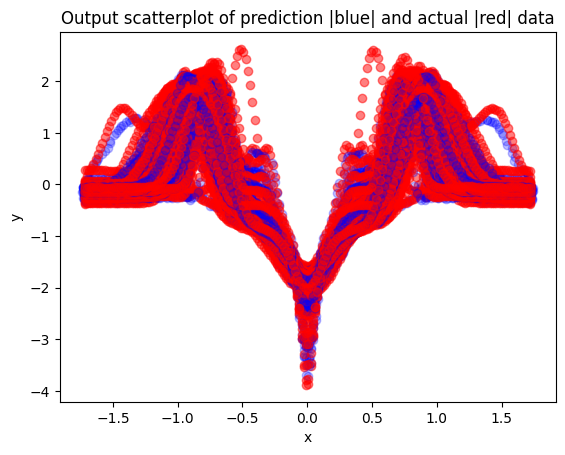

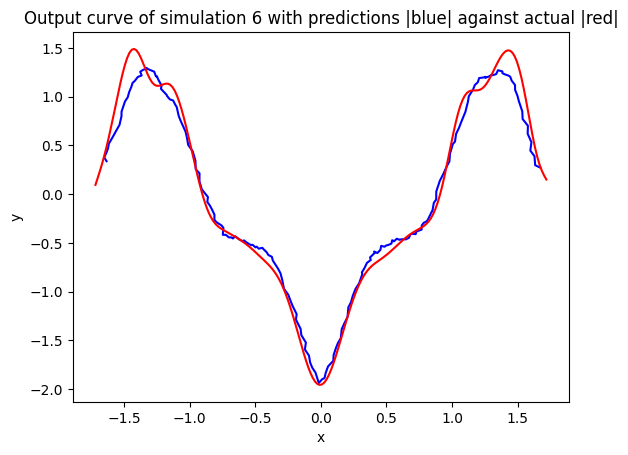

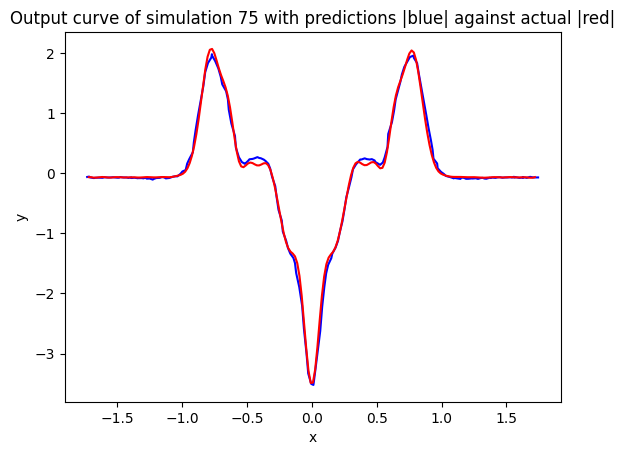

4/4 [==============================] - 0s 9ms/step


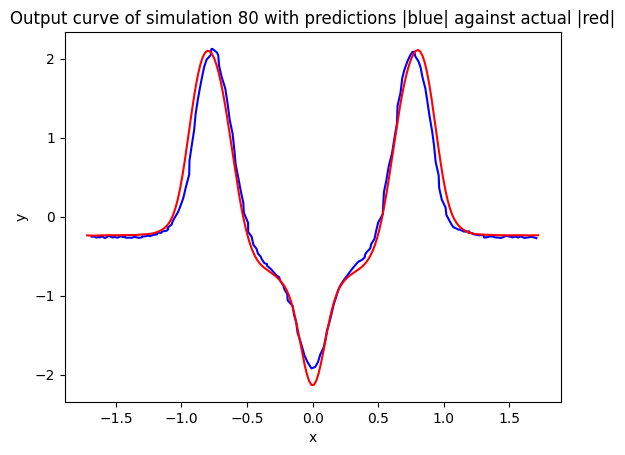

In [17]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.0004))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.0004))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu", bias_regularizer=l1(0.0004))(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_5_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_30 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_21 (Dropout)        (None, 2000)              0         
                                                                 
 dense_31 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_22 (Dropout)        (None, 1000)              0         
                                                                 
 dense_32 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_23 (Dropout)        (None, 1000)              0   

7/7 [==============================] - 2s 315ms/step - loss: 0.1145 - val_loss: 0.1411
Epoch 62/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1147 - val_loss: 0.1317
Epoch 63/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.1128 - val_loss: 0.1341
Epoch 64/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1112 - val_loss: 0.1379
Epoch 65/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1126 - val_loss: 0.1359
Epoch 66/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.1125 - val_loss: 0.1347
Epoch 67/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.1110 - val_loss: 0.1345
Epoch 68/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1108 - val_loss: 0.1313
Epoch 69/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.1090 - val_loss: 0.1297
Epoch 70/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.1107 - val_loss: 0.1315
Epoc

Epoch 142/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.0906 - val_loss: 0.1115
Epoch 143/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0902 - val_loss: 0.1179
Epoch 144/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0912 - val_loss: 0.1102
Epoch 145/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0860 - val_loss: 0.1112
Epoch 146/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0880 - val_loss: 0.1133
Epoch 147/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0895 - val_loss: 0.1103
Epoch 148/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0868 - val_loss: 0.1058
Epoch 149/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0880 - val_loss: 0.1176
Epoch 150/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0886 - val_loss: 0.1139
Epoch 151/1500
7/7 [==============================] - 2s 334ms/step - loss: 0.0895

7/7 [==============================] - 1s 125ms/step - loss: 0.0688 - val_loss: 0.0991
Epoch 303/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0637 - val_loss: 0.0972
Epoch 304/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0680 - val_loss: 0.0991
Epoch 305/1500
7/7 [==============================] - 1s 156ms/step - loss: 0.0635 - val_loss: 0.1035
Epoch 306/1500
7/7 [==============================] - 1s 198ms/step - loss: 0.0626 - val_loss: 0.1029
Epoch 307/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0624 - val_loss: 0.1003
Epoch 308/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0678 - val_loss: 0.1050
Epoch 309/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0701 - val_loss: 0.1091
Epoch 310/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0694 - val_loss: 0.1031
Epoch 311/1500
7/7 [==============================] - 2s 325ms/step - loss: 0.0660 - val_loss: 0.

7/7 [==============================] - 1s 124ms/step - loss: 0.0524 - val_loss: 0.0992
Epoch 463/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0498 - val_loss: 0.0985
Epoch 464/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0481 - val_loss: 0.0998
Epoch 465/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0549 - val_loss: 0.1032
Epoch 466/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.0582 - val_loss: 0.0996
Epoch 467/1500
7/7 [==============================] - 1s 129ms/step - loss: 0.0541 - val_loss: 0.1007
Epoch 468/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.0482 - val_loss: 0.0986
Epoch 469/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.0497 - val_loss: 0.0975
Epoch 470/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0495 - val_loss: 0.0994
Epoch 471/1500
7/7 [==============================] - 2s 341ms/step - loss: 0.0472 - val_loss: 0.

7/7 [==============================] - 1s 122ms/step - loss: 0.0469 - val_loss: 0.1072
Epoch 623/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0455 - val_loss: 0.1047
Epoch 624/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0410 - val_loss: 0.0992
Epoch 625/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0420 - val_loss: 0.1001
Epoch 626/1500
7/7 [==============================] - 1s 131ms/step - loss: 0.0400 - val_loss: 0.0970
Epoch 627/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0374 - val_loss: 0.0889
Epoch 628/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0429 - val_loss: 0.0919
Epoch 629/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0409 - val_loss: 0.0997
Epoch 630/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0394 - val_loss: 0.1001
Epoch 631/1500
7/7 [==============================] - 2s 379ms/step - loss: 0.0453 - val_loss: 0.

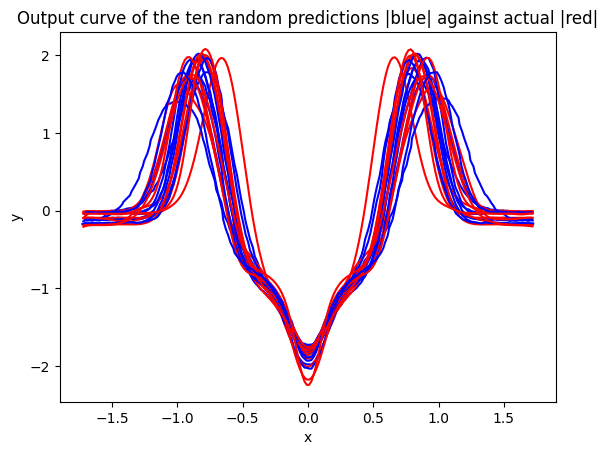

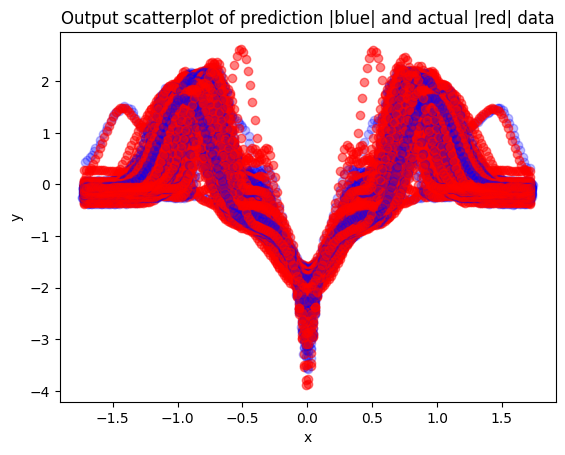

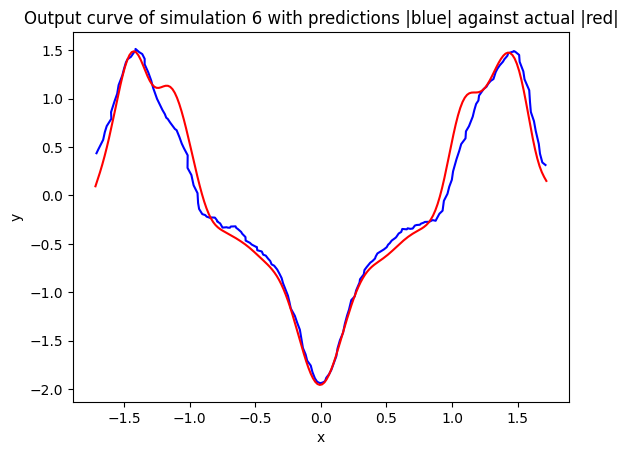

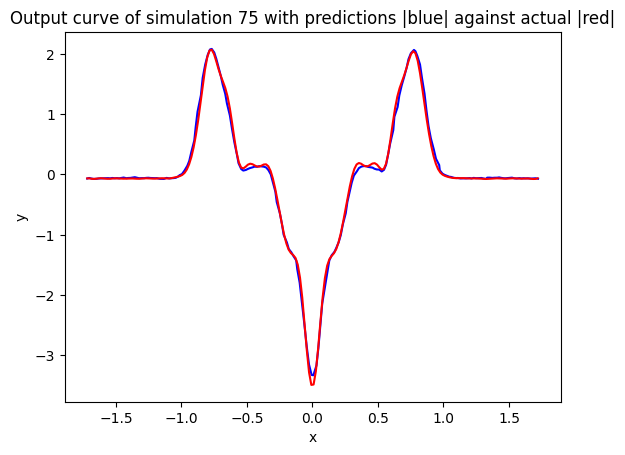

4/4 [==============================] - 0s 11ms/step


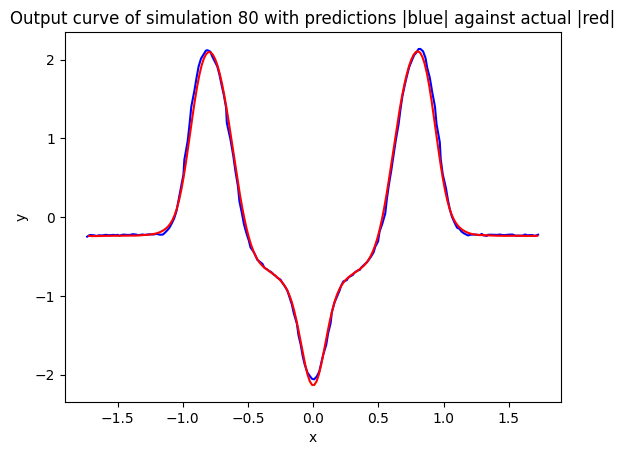

In [18]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.00001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.00001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.00001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.00001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu", bias_regularizer=l1(0.00001))(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_5_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_37 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_26 (Dropout)        (None, 2000)              0         
                                                                 
 dense_38 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_27 (Dropout)        (None, 1000)              0         
                                                                 
 dense_39 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_28 (Dropout)        (None, 1000)              0   

7/7 [==============================] - 2s 333ms/step - loss: 0.1646 - val_loss: 0.2393
Epoch 62/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.1718 - val_loss: 0.2731
Epoch 63/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1824 - val_loss: 0.1589
Epoch 64/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1648 - val_loss: 0.2050
Epoch 65/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1525 - val_loss: 0.1665
Epoch 66/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1574 - val_loss: 0.1776
Epoch 67/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.1557 - val_loss: 0.2113
Epoch 68/1500
7/7 [==============================] - 1s 151ms/step - loss: 0.1483 - val_loss: 0.2204
Epoch 69/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.1506 - val_loss: 0.2228
Epoch 70/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.1533 - val_loss: 0.2393
Epoc

Epoch 142/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1344 - val_loss: 0.2180
Epoch 143/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1282 - val_loss: 0.2350
Epoch 144/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1350 - val_loss: 0.2598
Epoch 145/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.1557 - val_loss: 0.1355
Epoch 146/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1768 - val_loss: 0.2123
Epoch 147/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1464 - val_loss: 0.1728
Epoch 148/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1330 - val_loss: 0.1962
Epoch 149/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.1311 - val_loss: 0.2246
Epoch 150/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.1303 - val_loss: 0.2007
Epoch 151/1500
7/7 [==============================] - 2s 334ms/step - loss: 0.1444

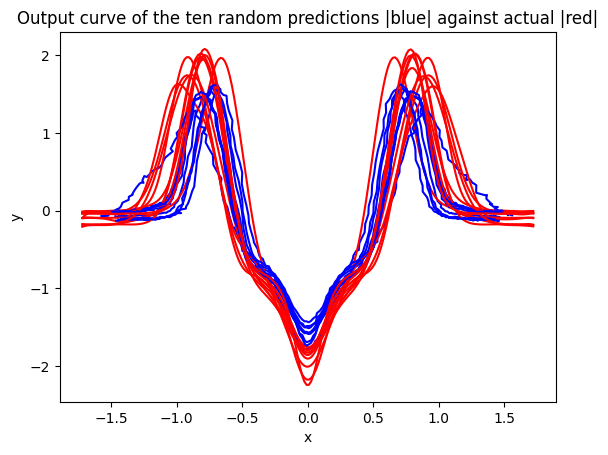

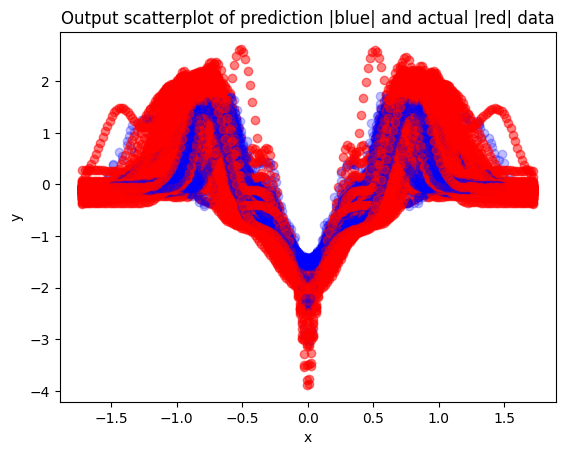

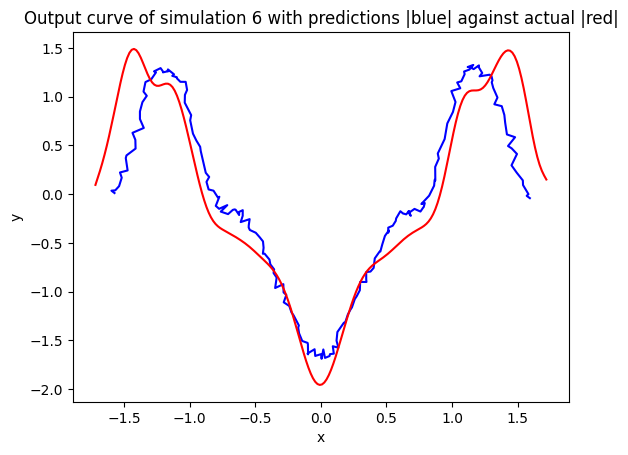

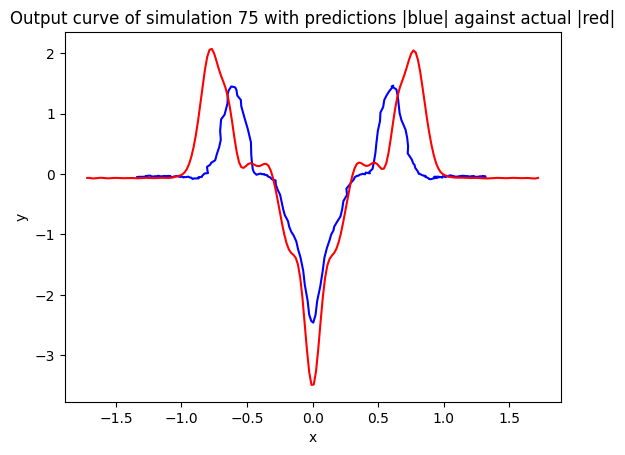

4/4 [==============================] - 0s 10ms/step


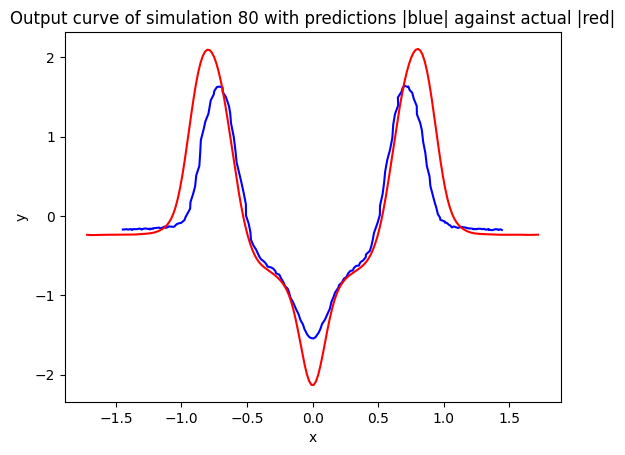

In [19]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.01))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.01))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.01))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.01))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu", bias_regularizer=l1(0.01))(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_5_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_44 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_31 (Dropout)        (None, 2000)              0         
                                                                 
 dense_45 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_32 (Dropout)        (None, 1000)              0         
                                                                 
 dense_46 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_33 (Dropout)        (None, 1000)              0   

7/7 [==============================] - 2s 315ms/step - loss: 0.1184 - val_loss: 0.1352
Epoch 62/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.1162 - val_loss: 0.1425
Epoch 63/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.1186 - val_loss: 0.1302
Epoch 64/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1134 - val_loss: 0.1327
Epoch 65/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1122 - val_loss: 0.1354
Epoch 66/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1121 - val_loss: 0.1365
Epoch 67/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1098 - val_loss: 0.1277
Epoch 68/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.1108 - val_loss: 0.1298
Epoch 69/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1083 - val_loss: 0.1318
Epoch 70/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.1123 - val_loss: 0.1275
Epoc

Epoch 142/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0881 - val_loss: 0.1121
Epoch 143/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0920 - val_loss: 0.1117
Epoch 144/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0879 - val_loss: 0.1118
Epoch 145/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0897 - val_loss: 0.1073
Epoch 146/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0888 - val_loss: 0.1117
Epoch 147/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0921 - val_loss: 0.1093
Epoch 148/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0901 - val_loss: 0.1095
Epoch 149/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0893 - val_loss: 0.1104
Epoch 150/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0851 - val_loss: 0.1105
Epoch 151/1500
7/7 [==============================] - 2s 322ms/step - loss: 0.0866

7/7 [==============================] - 1s 126ms/step - loss: 0.0638 - val_loss: 0.0932
Epoch 303/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0668 - val_loss: 0.1055
Epoch 304/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0653 - val_loss: 0.0961
Epoch 305/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0638 - val_loss: 0.0973
Epoch 306/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.0664 - val_loss: 0.0954
Epoch 307/1500
7/7 [==============================] - 1s 125ms/step - loss: 0.0649 - val_loss: 0.0961
Epoch 308/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0626 - val_loss: 0.0908
Epoch 309/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0622 - val_loss: 0.0971
Epoch 310/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0632 - val_loss: 0.0974
Epoch 311/1500
7/7 [==============================] - 2s 330ms/step - loss: 0.0664 - val_loss: 0.

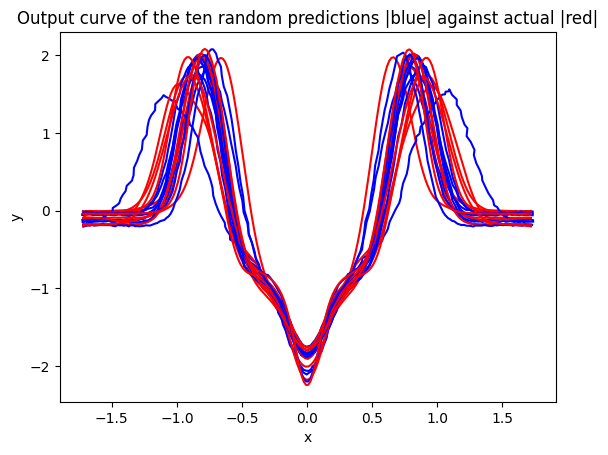

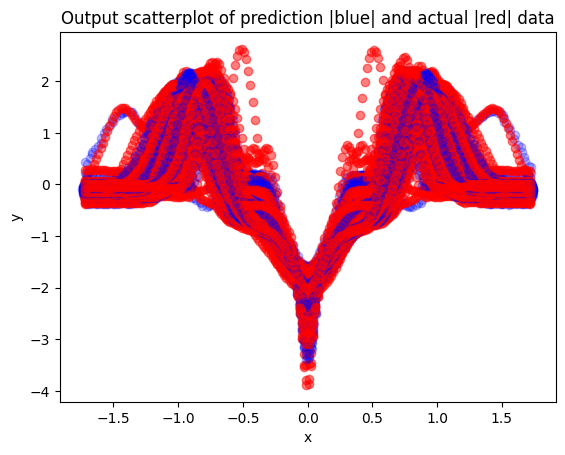

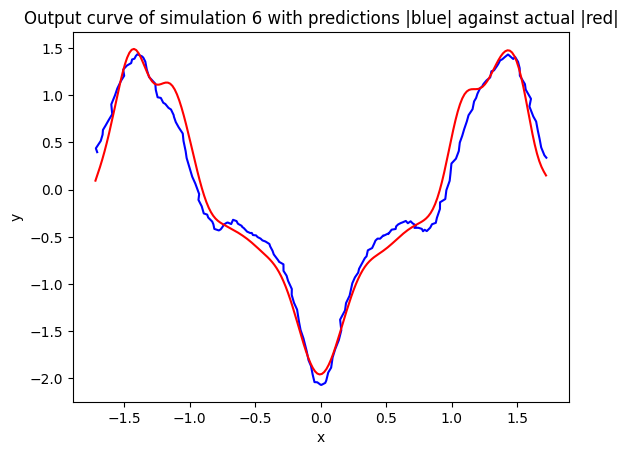

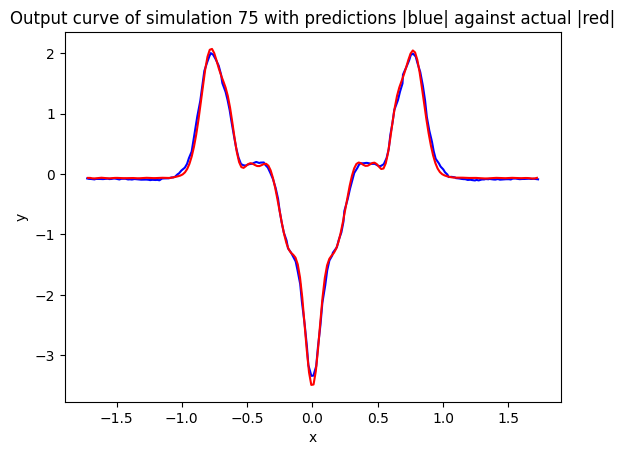

4/4 [==============================] - 0s 9ms/step


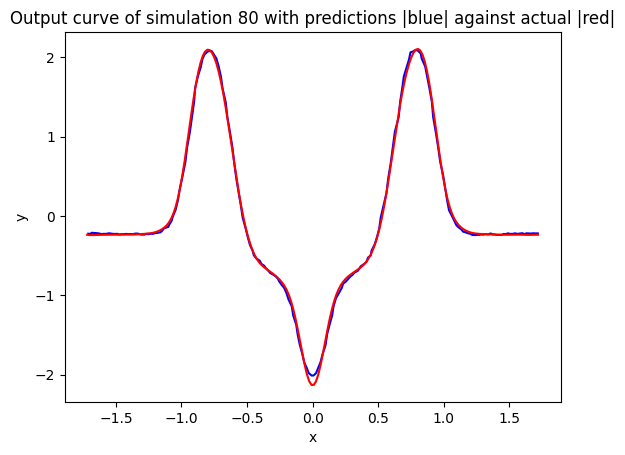

In [20]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.0000001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.0000001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.0000001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.0000001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu", bias_regularizer=l1(0.0000001))(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_5_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_51 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_36 (Dropout)        (None, 2000)              0         
                                                                 
 dense_52 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_37 (Dropout)        (None, 1000)              0         
                                                                 
 dense_53 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_38 (Dropout)        (None, 1000)              0   

7/7 [==============================] - 2s 334ms/step - loss: 0.1193 - val_loss: 0.1363
Epoch 62/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.1177 - val_loss: 0.1325
Epoch 63/1500
7/7 [==============================] - 1s 128ms/step - loss: 0.1176 - val_loss: 0.1363
Epoch 64/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.1163 - val_loss: 0.1330
Epoch 65/1500
7/7 [==============================] - 1s 129ms/step - loss: 0.1139 - val_loss: 0.1317
Epoch 66/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1146 - val_loss: 0.1334
Epoch 67/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.1160 - val_loss: 0.1318
Epoch 68/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.1134 - val_loss: 0.1320
Epoch 69/1500
7/7 [==============================] - 1s 127ms/step - loss: 0.1105 - val_loss: 0.1267
Epoch 70/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.1105 - val_loss: 0.1386
Epoc

Epoch 142/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0862 - val_loss: 0.1052
Epoch 143/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0838 - val_loss: 0.1068
Epoch 144/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0857 - val_loss: 0.1102
Epoch 145/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0893 - val_loss: 0.1081
Epoch 146/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0880 - val_loss: 0.1040
Epoch 147/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0895 - val_loss: 0.1116
Epoch 148/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0904 - val_loss: 0.1050
Epoch 149/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0890 - val_loss: 0.1109
Epoch 150/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0897 - val_loss: 0.1092
Epoch 151/1500
7/7 [==============================] - 2s 317ms/step - loss: 0.0888

7/7 [==============================] - 1s 123ms/step - loss: 0.0663 - val_loss: 0.1026
Epoch 303/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0726 - val_loss: 0.0988
Epoch 304/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0695 - val_loss: 0.0993
Epoch 305/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0677 - val_loss: 0.1018
Epoch 306/1500
7/7 [==============================] - 1s 115ms/step - loss: 0.0674 - val_loss: 0.1007
Epoch 307/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0683 - val_loss: 0.1027
Epoch 308/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0657 - val_loss: 0.1053
Epoch 309/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0680 - val_loss: 0.1011
Epoch 310/1500
7/7 [==============================] - 1s 120ms/step - loss: 0.0704 - val_loss: 0.1029
Epoch 311/1500
7/7 [==============================] - 2s 308ms/step - loss: 0.0690 - val_loss: 0.

7/7 [==============================] - 1s 124ms/step - loss: 0.0510 - val_loss: 0.1008
Epoch 463/1500
7/7 [==============================] - 1s 126ms/step - loss: 0.0534 - val_loss: 0.1093
Epoch 464/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0530 - val_loss: 0.1015
Epoch 465/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0540 - val_loss: 0.1033
Epoch 466/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0488 - val_loss: 0.1027
Epoch 467/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0510 - val_loss: 0.1002
Epoch 468/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0474 - val_loss: 0.1031
Epoch 469/1500
7/7 [==============================] - 1s 163ms/step - loss: 0.0485 - val_loss: 0.1026
Epoch 470/1500
7/7 [==============================] - 1s 118ms/step - loss: 0.0518 - val_loss: 0.1036
Epoch 471/1500
7/7 [==============================] - 2s 296ms/step - loss: 0.0501 - val_loss: 0.

7/7 [==============================] - 1s 119ms/step - loss: 0.0380 - val_loss: 0.0976
Epoch 623/1500
7/7 [==============================] - 1s 123ms/step - loss: 0.0392 - val_loss: 0.0964
Epoch 624/1500
7/7 [==============================] - 1s 121ms/step - loss: 0.0417 - val_loss: 0.0984
Epoch 625/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0392 - val_loss: 0.0987
Epoch 626/1500
7/7 [==============================] - 1s 122ms/step - loss: 0.0399 - val_loss: 0.0953
Epoch 627/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0410 - val_loss: 0.0990
Epoch 628/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0422 - val_loss: 0.1028
Epoch 629/1500
7/7 [==============================] - 1s 124ms/step - loss: 0.0438 - val_loss: 0.0985
Epoch 630/1500
7/7 [==============================] - 1s 119ms/step - loss: 0.0463 - val_loss: 0.0949
Epoch 631/1500
7/7 [==============================] - 2s 332ms/step - loss: 0.0419 - val_loss: 0.

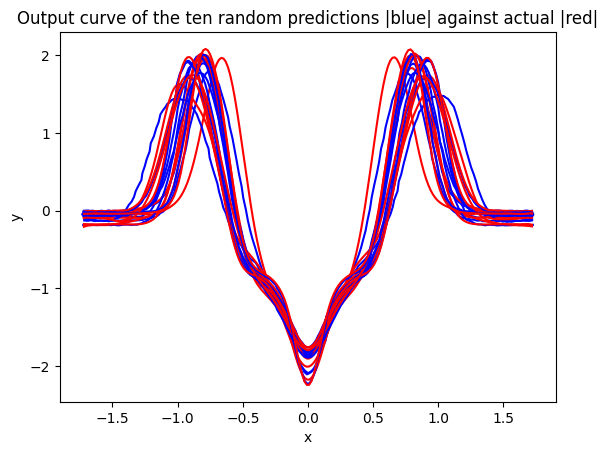

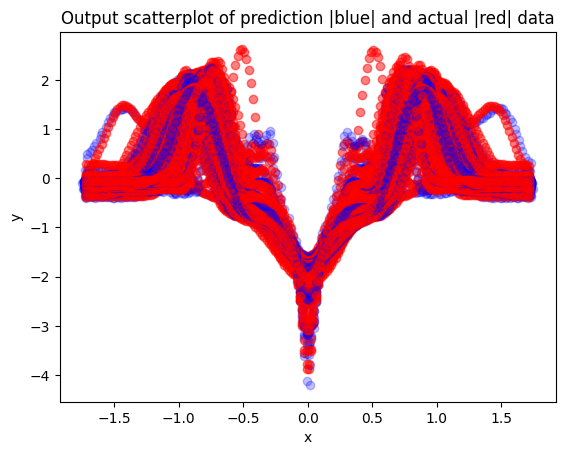

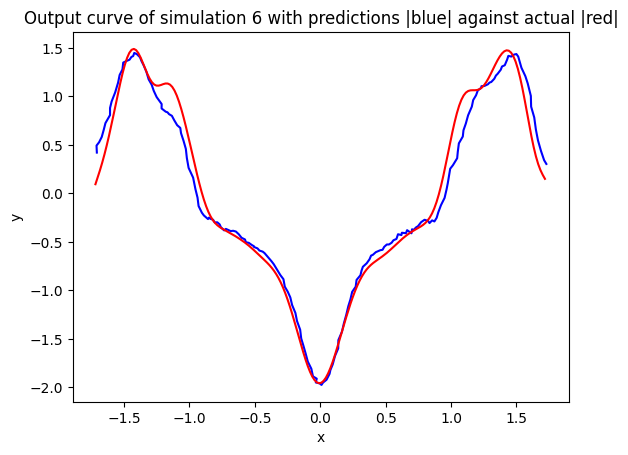

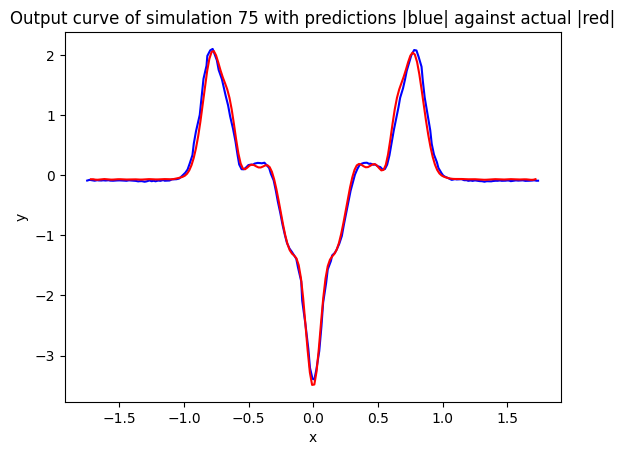

4/4 [==============================] - 0s 10ms/step


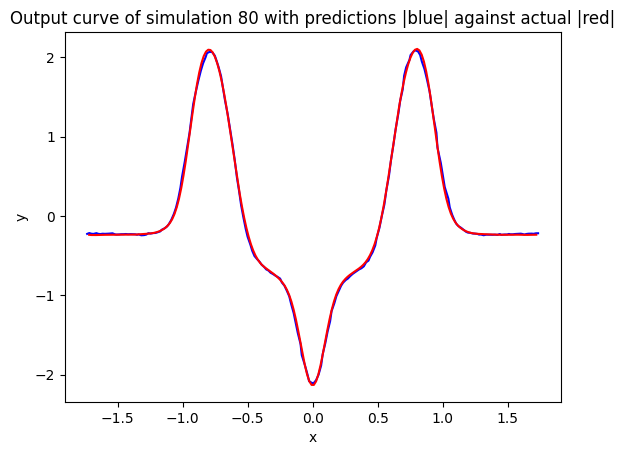

In [21]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_5_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_58 (Dense)            (None, 2000)              2002000   
                                                                 
 dropout_41 (Dropout)        (None, 2000)              0         
                                                                 
 dense_59 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_42 (Dropout)        (None, 1000)              0         
                                                                 
 dense_60 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_43 (Dropout)        (None, 1000)              0   

Epoch 48/1500
7/7 [==============================] - 1s 206ms/step - loss: 0.1384 - val_loss: 0.1488
Epoch 49/1500
7/7 [==============================] - 1s 203ms/step - loss: 0.1384 - val_loss: 0.1493
Epoch 50/1500
7/7 [==============================] - 1s 188ms/step - loss: 0.1387 - val_loss: 0.1429
Epoch 51/1500
7/7 [==============================] - 3s 533ms/step - loss: 0.1387 - val_loss: 0.1435
Epoch 52/1500
7/7 [==============================] - 1s 192ms/step - loss: 0.1374 - val_loss: 0.1494
Epoch 53/1500
7/7 [==============================] - 1s 202ms/step - loss: 0.1375 - val_loss: 0.1467
Epoch 54/1500
7/7 [==============================] - 2s 360ms/step - loss: 0.1377 - val_loss: 0.1448
Epoch 55/1500
7/7 [==============================] - 1s 202ms/step - loss: 0.1392 - val_loss: 0.1517
Epoch 56/1500
7/7 [==============================] - 1s 204ms/step - loss: 0.1387 - val_loss: 0.1436
Epoch 57/1500
7/7 [==============================] - 1s 193ms/step - loss: 0.1373 - val_los

Epoch 129/1500
7/7 [==============================] - 1s 202ms/step - loss: 0.1338 - val_loss: 0.1533
Epoch 130/1500
7/7 [==============================] - 1s 188ms/step - loss: 0.1360 - val_loss: 0.1472
Epoch 131/1500
7/7 [==============================] - 3s 530ms/step - loss: 0.1351 - val_loss: 0.1479
Epoch 132/1500
7/7 [==============================] - 1s 189ms/step - loss: 0.1340 - val_loss: 0.1429
Epoch 133/1500
7/7 [==============================] - 1s 204ms/step - loss: 0.1343 - val_loss: 0.1482
Epoch 134/1500
7/7 [==============================] - 1s 209ms/step - loss: 0.1343 - val_loss: 0.1478
Epoch 135/1500
7/7 [==============================] - 1s 205ms/step - loss: 0.1332 - val_loss: 0.1418
Epoch 136/1500
7/7 [==============================] - 1s 189ms/step - loss: 0.1331 - val_loss: 0.1469
Epoch 137/1500
7/7 [==============================] - 1s 210ms/step - loss: 0.1329 - val_loss: 0.1469
Epoch 138/1500
7/7 [==============================] - 1s 205ms/step - loss: 0.1326

7/7 [==============================] - 1s 202ms/step - loss: 0.1309 - val_loss: 0.1440
Epoch 290/1500
7/7 [==============================] - 1s 201ms/step - loss: 0.1311 - val_loss: 0.1436
Epoch 291/1500
7/7 [==============================] - 3s 520ms/step - loss: 0.1318 - val_loss: 0.1456
Epoch 292/1500
7/7 [==============================] - 1s 205ms/step - loss: 0.1309 - val_loss: 0.1448
Epoch 293/1500
7/7 [==============================] - 1s 191ms/step - loss: 0.1307 - val_loss: 0.1463
Epoch 294/1500
7/7 [==============================] - 1s 208ms/step - loss: 0.1308 - val_loss: 0.1472
Epoch 295/1500
7/7 [==============================] - 1s 201ms/step - loss: 0.1316 - val_loss: 0.1440
Epoch 296/1500
7/7 [==============================] - 1s 204ms/step - loss: 0.1313 - val_loss: 0.1445
Epoch 297/1500
7/7 [==============================] - 1s 209ms/step - loss: 0.1309 - val_loss: 0.1468
Epoch 298/1500
7/7 [==============================] - 1s 192ms/step - loss: 0.1314 - val_loss: 0.

7/7 [==============================] - 1s 198ms/step - loss: 0.1045 - val_loss: 0.1293
Epoch 450/1500
7/7 [==============================] - 1s 213ms/step - loss: 0.1093 - val_loss: 0.1317
Epoch 451/1500
7/7 [==============================] - 3s 536ms/step - loss: 0.1075 - val_loss: 0.1272
Epoch 452/1500
7/7 [==============================] - 1s 215ms/step - loss: 0.1057 - val_loss: 0.1313
Epoch 453/1500
7/7 [==============================] - 1s 199ms/step - loss: 0.1064 - val_loss: 0.1294
Epoch 454/1500
7/7 [==============================] - 2s 227ms/step - loss: 0.1034 - val_loss: 0.1281
Epoch 455/1500
7/7 [==============================] - 2s 249ms/step - loss: 0.1059 - val_loss: 0.1295
Epoch 456/1500
7/7 [==============================] - 2s 223ms/step - loss: 0.1076 - val_loss: 0.1327
Epoch 457/1500
7/7 [==============================] - 1s 222ms/step - loss: 0.1059 - val_loss: 0.1310
Epoch 458/1500
7/7 [==============================] - 1s 207ms/step - loss: 0.1159 - val_loss: 0.

7/7 [==============================] - 2s 363ms/step - loss: 0.0924 - val_loss: 0.1204
Epoch 610/1500
7/7 [==============================] - 1s 206ms/step - loss: 0.0927 - val_loss: 0.1214
Epoch 611/1500
7/7 [==============================] - 3s 524ms/step - loss: 0.0953 - val_loss: 0.1163
Epoch 612/1500
7/7 [==============================] - 1s 202ms/step - loss: 0.0930 - val_loss: 0.1168
Epoch 613/1500
7/7 [==============================] - 2s 242ms/step - loss: 0.0921 - val_loss: 0.1175
Epoch 614/1500
7/7 [==============================] - 1s 209ms/step - loss: 0.0935 - val_loss: 0.1176
Epoch 615/1500
7/7 [==============================] - 1s 205ms/step - loss: 0.0931 - val_loss: 0.1179
Epoch 616/1500
7/7 [==============================] - 1s 207ms/step - loss: 0.0917 - val_loss: 0.1175
Epoch 617/1500
7/7 [==============================] - 2s 240ms/step - loss: 0.0927 - val_loss: 0.1169
Epoch 618/1500
7/7 [==============================] - 1s 205ms/step - loss: 0.0937 - val_loss: 0.

7/7 [==============================] - 1s 210ms/step - loss: 0.0856 - val_loss: 0.1109
Epoch 770/1500
7/7 [==============================] - 1s 197ms/step - loss: 0.0901 - val_loss: 0.1126
Epoch 771/1500
7/7 [==============================] - 3s 553ms/step - loss: 0.0878 - val_loss: 0.1108
Epoch 772/1500
7/7 [==============================] - 1s 198ms/step - loss: 0.0855 - val_loss: 0.1098
Epoch 773/1500
7/7 [==============================] - 1s 196ms/step - loss: 0.0850 - val_loss: 0.1093
Epoch 774/1500
7/7 [==============================] - 1s 205ms/step - loss: 0.0837 - val_loss: 0.1078
Epoch 775/1500
7/7 [==============================] - 1s 191ms/step - loss: 0.0835 - val_loss: 0.1075
Epoch 776/1500
7/7 [==============================] - 1s 192ms/step - loss: 0.0823 - val_loss: 0.1069
Epoch 777/1500
7/7 [==============================] - 1s 205ms/step - loss: 0.0812 - val_loss: 0.1064
Epoch 778/1500
7/7 [==============================] - 1s 206ms/step - loss: 0.0800 - val_loss: 0.

7/7 [==============================] - 1s 204ms/step - loss: 0.0820 - val_loss: 0.1123
Epoch 930/1500
7/7 [==============================] - 1s 189ms/step - loss: 0.0805 - val_loss: 0.1128
Epoch 931/1500
7/7 [==============================] - 3s 524ms/step - loss: 0.0804 - val_loss: 0.1161
Epoch 932/1500
7/7 [==============================] - 1s 195ms/step - loss: 0.0788 - val_loss: 0.1060
Epoch 933/1500
7/7 [==============================] - 1s 204ms/step - loss: 0.0819 - val_loss: 0.1064
Epoch 934/1500
7/7 [==============================] - 1s 205ms/step - loss: 0.0801 - val_loss: 0.1079
Epoch 935/1500
7/7 [==============================] - 1s 203ms/step - loss: 0.0806 - val_loss: 0.1054
Epoch 936/1500
7/7 [==============================] - 1s 190ms/step - loss: 0.0821 - val_loss: 0.1101
Epoch 937/1500
7/7 [==============================] - 2s 234ms/step - loss: 0.0846 - val_loss: 0.1090
Epoch 938/1500
7/7 [==============================] - 2s 236ms/step - loss: 0.0823 - val_loss: 0.

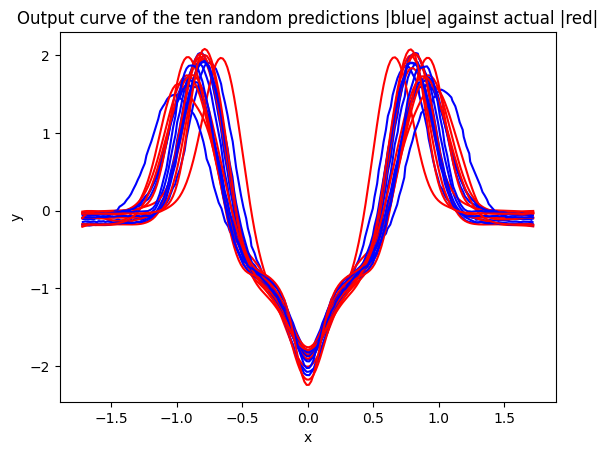

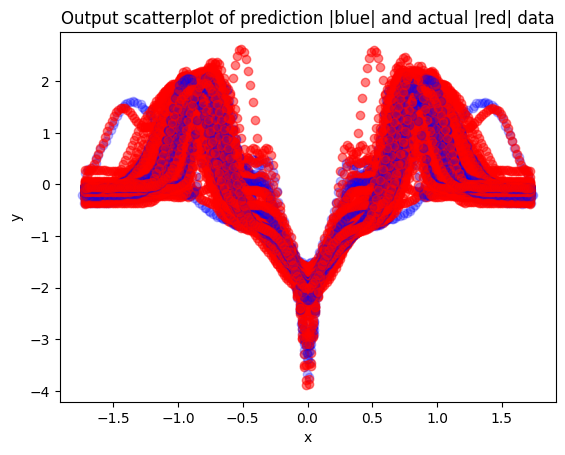

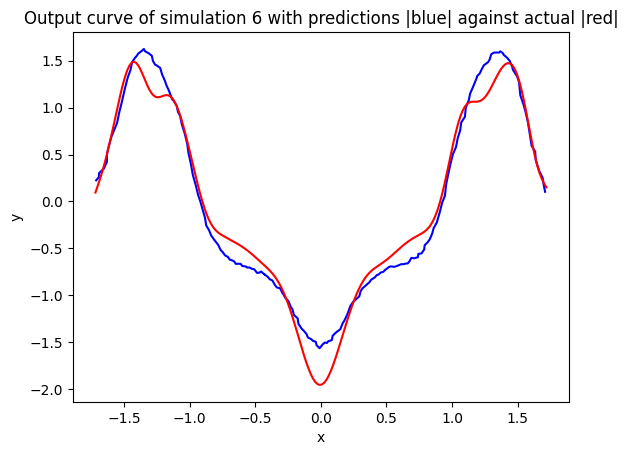

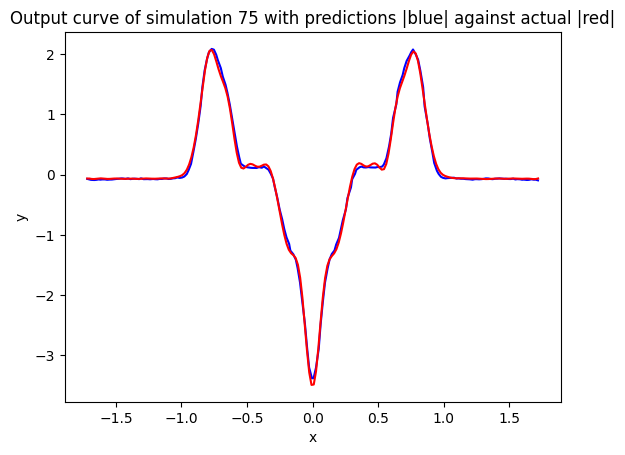

4/4 [==============================] - 0s 14ms/step


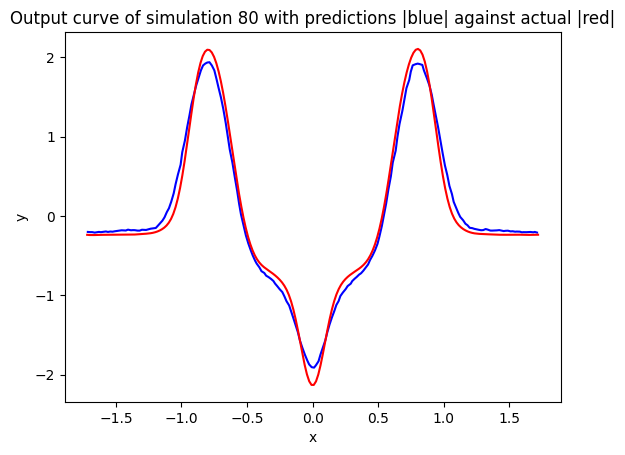

In [22]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(500, activation="relu")(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=150),
             TensorBoard(log_dir='model_5_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 4000)              4004000   
                                                                 
 dropout (Dropout)           (None, 4000)              0         
                                                                 
 dense_1 (Dense)             (None, 2000)              8002000   
                                                                 
 dropout_1 (Dropout)         (None, 2000)              0         
                                                                 
 dense_2 (Dense)             (None, 2000)              4002000   
                                                                 
 dropout_2 (Dropout)         (None, 2000)              0     

Epoch 60/1500
7/7 [==============================] - 2s 364ms/step - loss: 0.1358 - val_loss: 0.1342
Epoch 61/1500
7/7 [==============================] - 6s 1s/step - loss: 0.1359 - val_loss: 0.1374
Epoch 62/1500
7/7 [==============================] - 3s 368ms/step - loss: 0.1339 - val_loss: 0.1376
Epoch 63/1500
7/7 [==============================] - 2s 361ms/step - loss: 0.1341 - val_loss: 0.1384
Epoch 64/1500
7/7 [==============================] - 2s 362ms/step - loss: 0.1349 - val_loss: 0.1428
Epoch 65/1500
7/7 [==============================] - 2s 361ms/step - loss: 0.1341 - val_loss: 0.1356
Epoch 66/1500
7/7 [==============================] - 2s 356ms/step - loss: 0.1324 - val_loss: 0.1387
Epoch 67/1500
7/7 [==============================] - 2s 355ms/step - loss: 0.1325 - val_loss: 0.1422
Epoch 68/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.1301 - val_loss: 0.1438
Epoch 69/1500
7/7 [==============================] - 3s 367ms/step - loss: 0.1303 - val_loss: 

Epoch 141/1500
7/7 [==============================] - 6s 971ms/step - loss: 0.1004 - val_loss: 0.1157
Epoch 142/1500
7/7 [==============================] - 2s 353ms/step - loss: 0.1010 - val_loss: 0.1147
Epoch 143/1500
7/7 [==============================] - 3s 368ms/step - loss: 0.0985 - val_loss: 0.1148
Epoch 144/1500
7/7 [==============================] - 2s 362ms/step - loss: 0.0997 - val_loss: 0.1114
Epoch 145/1500
7/7 [==============================] - 3s 370ms/step - loss: 0.0973 - val_loss: 0.1141
Epoch 146/1500
7/7 [==============================] - 2s 360ms/step - loss: 0.0972 - val_loss: 0.1158
Epoch 147/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.0991 - val_loss: 0.1173
Epoch 148/1500
7/7 [==============================] - 3s 359ms/step - loss: 0.0977 - val_loss: 0.1181
Epoch 149/1500
7/7 [==============================] - 2s 354ms/step - loss: 0.1016 - val_loss: 0.1143
Epoch 150/1500
7/7 [==============================] - 3s 366ms/step - loss: 0.0990

7/7 [==============================] - 6s 1s/step - loss: 0.0736 - val_loss: 0.1008
Epoch 302/1500
7/7 [==============================] - 3s 364ms/step - loss: 0.0689 - val_loss: 0.0940
Epoch 303/1500
7/7 [==============================] - 3s 512ms/step - loss: 0.0751 - val_loss: 0.1019
Epoch 304/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.0768 - val_loss: 0.1000
Epoch 305/1500
7/7 [==============================] - 2s 360ms/step - loss: 0.0772 - val_loss: 0.1043
Epoch 306/1500
7/7 [==============================] - 3s 365ms/step - loss: 0.0745 - val_loss: 0.1001
Epoch 307/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.0752 - val_loss: 0.0989
Epoch 308/1500
7/7 [==============================] - 3s 368ms/step - loss: 0.0731 - val_loss: 0.0988
Epoch 309/1500
7/7 [==============================] - 3s 365ms/step - loss: 0.0706 - val_loss: 0.1019
Epoch 310/1500
7/7 [==============================] - 2s 365ms/step - loss: 0.0697 - val_loss: 0.105

7/7 [==============================] - 6s 1s/step - loss: 0.0568 - val_loss: 0.1026
Epoch 462/1500
7/7 [==============================] - 2s 352ms/step - loss: 0.0608 - val_loss: 0.1000
Epoch 463/1500
7/7 [==============================] - 2s 353ms/step - loss: 0.0633 - val_loss: 0.1109
Epoch 464/1500
7/7 [==============================] - 3s 365ms/step - loss: 0.0641 - val_loss: 0.1054
Epoch 465/1500
7/7 [==============================] - 2s 359ms/step - loss: 0.0648 - val_loss: 0.1032
Epoch 466/1500
7/7 [==============================] - 2s 364ms/step - loss: 0.0602 - val_loss: 0.1029
Epoch 467/1500
7/7 [==============================] - 2s 356ms/step - loss: 0.0657 - val_loss: 0.1020
Epoch 468/1500
7/7 [==============================] - 2s 362ms/step - loss: 0.0652 - val_loss: 0.0989
Epoch 469/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.0649 - val_loss: 0.0951
Epoch 470/1500
7/7 [==============================] - 2s 353ms/step - loss: 0.0597 - val_loss: 0.097

7/7 [==============================] - 6s 991ms/step - loss: 0.0512 - val_loss: 0.1024
Epoch 622/1500
7/7 [==============================] - 2s 353ms/step - loss: 0.0494 - val_loss: 0.1021
Epoch 623/1500
7/7 [==============================] - 2s 361ms/step - loss: 0.0496 - val_loss: 0.0992
Epoch 624/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.0527 - val_loss: 0.0970
Epoch 625/1500
7/7 [==============================] - 2s 363ms/step - loss: 0.0499 - val_loss: 0.1014
Epoch 626/1500
7/7 [==============================] - 2s 361ms/step - loss: 0.0513 - val_loss: 0.0953
Epoch 627/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.0482 - val_loss: 0.0961
Epoch 628/1500
7/7 [==============================] - 2s 349ms/step - loss: 0.0548 - val_loss: 0.0956
Epoch 629/1500
7/7 [==============================] - 3s 369ms/step - loss: 0.0572 - val_loss: 0.0937
Epoch 630/1500
7/7 [==============================] - 2s 348ms/step - loss: 0.0565 - val_loss: 0.

7/7 [==============================] - 6s 1s/step - loss: 0.0448 - val_loss: 0.0979
Epoch 782/1500
7/7 [==============================] - 3s 510ms/step - loss: 0.0460 - val_loss: 0.1060
Epoch 783/1500
7/7 [==============================] - 3s 392ms/step - loss: 0.0438 - val_loss: 0.0953
Epoch 784/1500
7/7 [==============================] - 3s 384ms/step - loss: 0.0441 - val_loss: 0.0934
Epoch 785/1500
7/7 [==============================] - 3s 384ms/step - loss: 0.0467 - val_loss: 0.1013
Epoch 786/1500
7/7 [==============================] - 3s 389ms/step - loss: 0.0454 - val_loss: 0.1128
Epoch 787/1500
7/7 [==============================] - 3s 362ms/step - loss: 0.0475 - val_loss: 0.1027
Epoch 788/1500
7/7 [==============================] - 3s 368ms/step - loss: 0.0452 - val_loss: 0.1043
Epoch 789/1500
7/7 [==============================] - 2s 355ms/step - loss: 0.0453 - val_loss: 0.1033
Epoch 790/1500
7/7 [==============================] - 2s 353ms/step - loss: 0.0424 - val_loss: 0.106

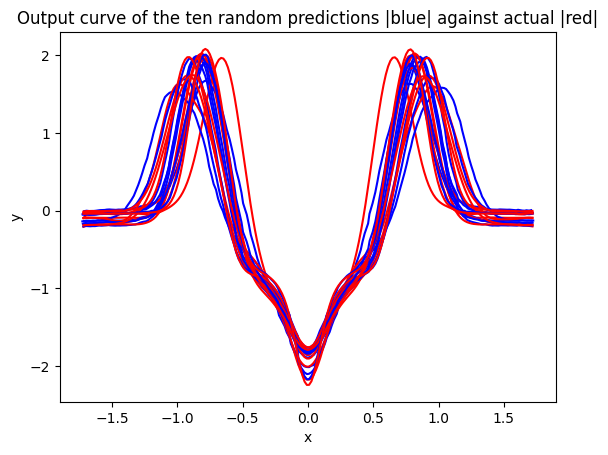

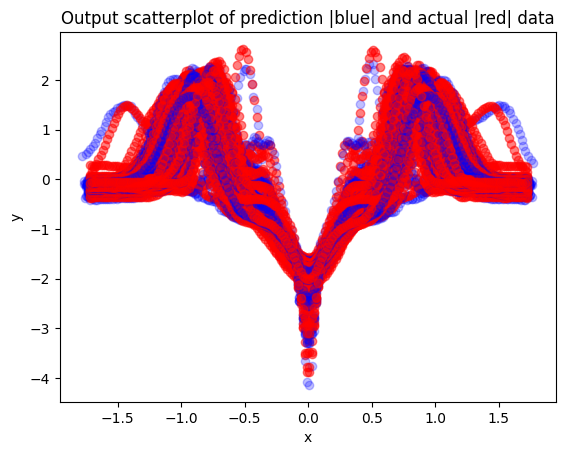

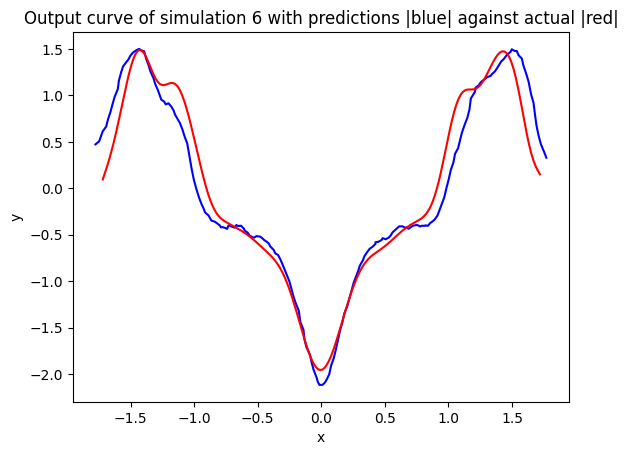

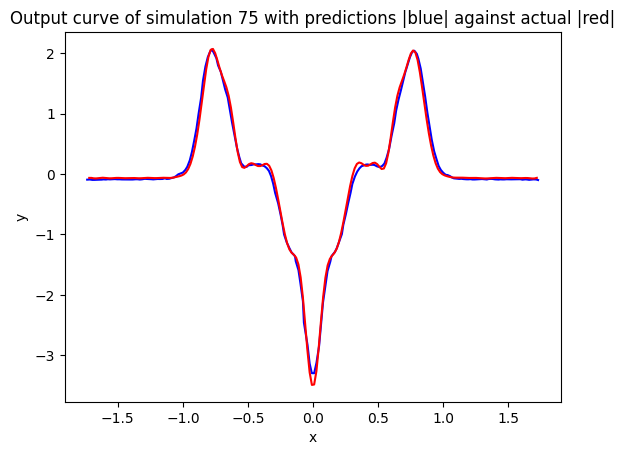

4/4 [==============================] - 0s 22ms/step


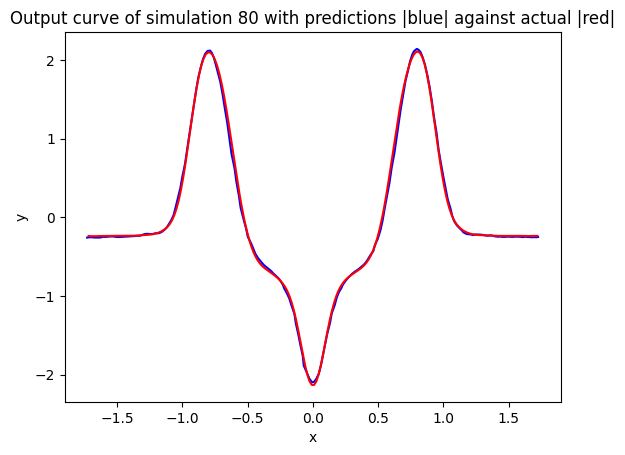

In [14]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(4000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.10, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=250),
             TensorBoard(log_dir='model_5_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_7 (Dense)             (None, 4000)              4004000   
                                                                 
 dropout_6 (Dropout)         (None, 4000)              0         
                                                                 
 dense_8 (Dense)             (None, 2000)              8002000   
                                                                 
 dropout_7 (Dropout)         (None, 2000)              0         
                                                                 
 dense_9 (Dense)             (None, 2000)              4002000   
                                                                 
 dropout_8 (Dropout)         (None, 2000)              0   

Epoch 60/1500
7/7 [==============================] - 2s 360ms/step - loss: 0.1408 - val_loss: 0.1414
Epoch 61/1500
7/7 [==============================] - 6s 988ms/step - loss: 0.1386 - val_loss: 0.1436
Epoch 62/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.1369 - val_loss: 0.1347
Epoch 63/1500
7/7 [==============================] - 2s 362ms/step - loss: 0.1371 - val_loss: 0.1365
Epoch 64/1500
7/7 [==============================] - 2s 362ms/step - loss: 0.1377 - val_loss: 0.1375
Epoch 65/1500
7/7 [==============================] - 2s 359ms/step - loss: 0.1355 - val_loss: 0.1365
Epoch 66/1500
7/7 [==============================] - 2s 359ms/step - loss: 0.1349 - val_loss: 0.1394
Epoch 67/1500
7/7 [==============================] - 2s 360ms/step - loss: 0.1371 - val_loss: 0.1371
Epoch 68/1500
7/7 [==============================] - 2s 359ms/step - loss: 0.1360 - val_loss: 0.1413
Epoch 69/1500
7/7 [==============================] - 2s 355ms/step - loss: 0.1338 - val_los

Epoch 141/1500
7/7 [==============================] - 6s 986ms/step - loss: 0.1102 - val_loss: 0.1217
Epoch 142/1500
7/7 [==============================] - 2s 336ms/step - loss: 0.1085 - val_loss: 0.1201
Epoch 143/1500
7/7 [==============================] - 2s 361ms/step - loss: 0.1091 - val_loss: 0.1196
Epoch 144/1500
7/7 [==============================] - 3s 369ms/step - loss: 0.1088 - val_loss: 0.1203
Epoch 145/1500
7/7 [==============================] - 2s 356ms/step - loss: 0.1109 - val_loss: 0.1253
Epoch 146/1500
7/7 [==============================] - 2s 356ms/step - loss: 0.1114 - val_loss: 0.1291
Epoch 147/1500
7/7 [==============================] - 2s 356ms/step - loss: 0.1101 - val_loss: 0.1241
Epoch 148/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.1092 - val_loss: 0.1240
Epoch 149/1500
7/7 [==============================] - 2s 359ms/step - loss: 0.1094 - val_loss: 0.1219
Epoch 150/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.1083

7/7 [==============================] - 6s 985ms/step - loss: 0.0931 - val_loss: 0.1009
Epoch 302/1500
7/7 [==============================] - 2s 353ms/step - loss: 0.0913 - val_loss: 0.0994
Epoch 303/1500
7/7 [==============================] - 2s 349ms/step - loss: 0.0929 - val_loss: 0.1055
Epoch 304/1500
7/7 [==============================] - 2s 359ms/step - loss: 0.0927 - val_loss: 0.1040
Epoch 305/1500
7/7 [==============================] - 2s 354ms/step - loss: 0.0924 - val_loss: 0.1057
Epoch 306/1500
7/7 [==============================] - 2s 361ms/step - loss: 0.0930 - val_loss: 0.1052
Epoch 307/1500
7/7 [==============================] - 2s 359ms/step - loss: 0.0940 - val_loss: 0.1047
Epoch 308/1500
7/7 [==============================] - 2s 360ms/step - loss: 0.0938 - val_loss: 0.1038
Epoch 309/1500
7/7 [==============================] - 2s 361ms/step - loss: 0.0910 - val_loss: 0.1057
Epoch 310/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.0911 - val_loss: 0.

7/7 [==============================] - 6s 999ms/step - loss: 0.0870 - val_loss: 0.1038
Epoch 462/1500
7/7 [==============================] - 2s 352ms/step - loss: 0.0854 - val_loss: 0.1030
Epoch 463/1500
7/7 [==============================] - 2s 362ms/step - loss: 0.0859 - val_loss: 0.0987
Epoch 464/1500
7/7 [==============================] - 2s 355ms/step - loss: 0.0861 - val_loss: 0.1011
Epoch 465/1500
7/7 [==============================] - 2s 356ms/step - loss: 0.0861 - val_loss: 0.1020
Epoch 466/1500
7/7 [==============================] - 2s 355ms/step - loss: 0.0856 - val_loss: 0.1036
Epoch 467/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.0845 - val_loss: 0.1071
Epoch 468/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.0863 - val_loss: 0.1084
Epoch 469/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.0878 - val_loss: 0.1091
Epoch 470/1500
7/7 [==============================] - 2s 355ms/step - loss: 0.0902 - val_loss: 0.

7/7 [==============================] - 6s 1s/step - loss: 0.0863 - val_loss: 0.1059
Epoch 622/1500
7/7 [==============================] - 2s 355ms/step - loss: 0.0846 - val_loss: 0.1049
Epoch 623/1500
7/7 [==============================] - 2s 359ms/step - loss: 0.0811 - val_loss: 0.1032
Epoch 624/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.0841 - val_loss: 0.1077
Epoch 625/1500
7/7 [==============================] - 2s 361ms/step - loss: 0.0877 - val_loss: 0.1054
Epoch 626/1500
7/7 [==============================] - 3s 364ms/step - loss: 0.0839 - val_loss: 0.1045
Epoch 627/1500
7/7 [==============================] - 3s 369ms/step - loss: 0.0812 - val_loss: 0.1060
Epoch 628/1500
7/7 [==============================] - 3s 370ms/step - loss: 0.0859 - val_loss: 0.1025
Epoch 629/1500
7/7 [==============================] - 3s 460ms/step - loss: 0.0874 - val_loss: 0.1079
Epoch 630/1500
7/7 [==============================] - 4s 553ms/step - loss: 0.0840 - val_loss: 0.106

7/7 [==============================] - 6s 1s/step - loss: 0.0770 - val_loss: 0.1048
Epoch 782/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.0776 - val_loss: 0.1045
Epoch 783/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.0759 - val_loss: 0.0991
Epoch 784/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.0759 - val_loss: 0.0986
Epoch 785/1500
7/7 [==============================] - 3s 382ms/step - loss: 0.0781 - val_loss: 0.1035
Epoch 786/1500
7/7 [==============================] - 2s 365ms/step - loss: 0.0798 - val_loss: 0.1004
Epoch 787/1500
7/7 [==============================] - 3s 413ms/step - loss: 0.0802 - val_loss: 0.0999
Epoch 788/1500
7/7 [==============================] - 3s 408ms/step - loss: 0.0781 - val_loss: 0.1011
Epoch 789/1500
7/7 [==============================] - 3s 404ms/step - loss: 0.0785 - val_loss: 0.1029
Epoch 790/1500
7/7 [==============================] - 3s 409ms/step - loss: 0.0756 - val_loss: 0.104

7/7 [==============================] - 7s 1s/step - loss: 0.0793 - val_loss: 0.0998
Epoch 942/1500
7/7 [==============================] - 2s 362ms/step - loss: 0.0787 - val_loss: 0.1024
Epoch 943/1500
7/7 [==============================] - 3s 370ms/step - loss: 0.0771 - val_loss: 0.1027
Epoch 944/1500
7/7 [==============================] - 3s 372ms/step - loss: 0.0770 - val_loss: 0.0997
Epoch 945/1500
7/7 [==============================] - 2s 360ms/step - loss: 0.0783 - val_loss: 0.1016
Epoch 946/1500
7/7 [==============================] - 2s 345ms/step - loss: 0.0795 - val_loss: 0.0984
Epoch 947/1500
7/7 [==============================] - 2s 361ms/step - loss: 0.0735 - val_loss: 0.0983
Epoch 948/1500
7/7 [==============================] - 3s 366ms/step - loss: 0.0766 - val_loss: 0.0991
Epoch 949/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.0758 - val_loss: 0.0972
Epoch 950/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.0779 - val_loss: 0.100

Epoch 1101/1500
7/7 [==============================] - 6s 990ms/step - loss: 0.0680 - val_loss: 0.1015
Epoch 1102/1500
7/7 [==============================] - 3s 379ms/step - loss: 0.0715 - val_loss: 0.0990
Epoch 1103/1500
7/7 [==============================] - 2s 362ms/step - loss: 0.0698 - val_loss: 0.1048
Epoch 1104/1500
7/7 [==============================] - 2s 356ms/step - loss: 0.0718 - val_loss: 0.1036
Epoch 1105/1500
7/7 [==============================] - 3s 386ms/step - loss: 0.0702 - val_loss: 0.1009
Epoch 1106/1500
7/7 [==============================] - 2s 362ms/step - loss: 0.0723 - val_loss: 0.1022
Epoch 1107/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.0721 - val_loss: 0.1011
Epoch 1108/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.0700 - val_loss: 0.1027
Epoch 1109/1500
7/7 [==============================] - 3s 356ms/step - loss: 0.0696 - val_loss: 0.1027
Epoch 1110/1500
7/7 [==============================] - 2s 355ms/step - lo

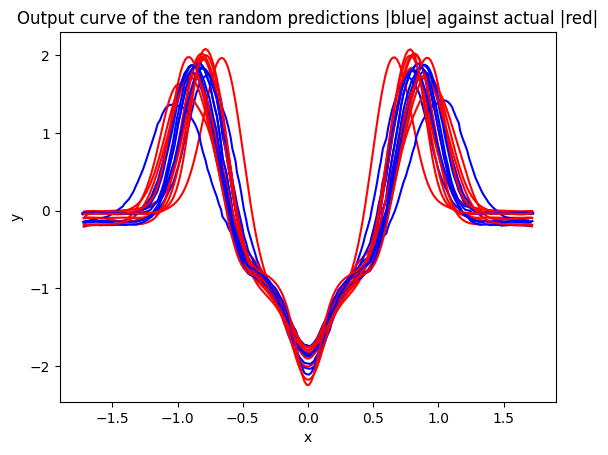

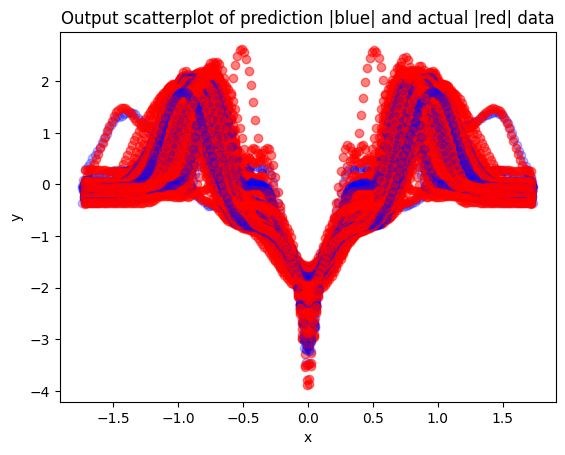

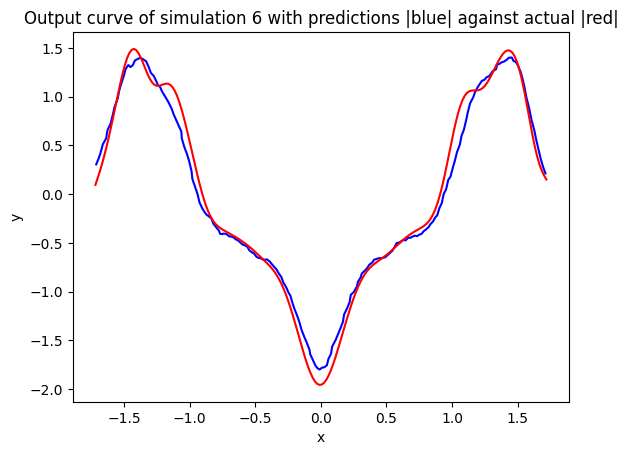

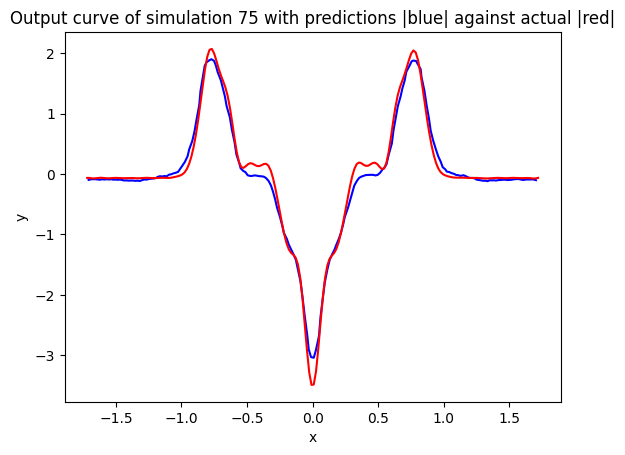

4/4 [==============================] - 0s 20ms/step


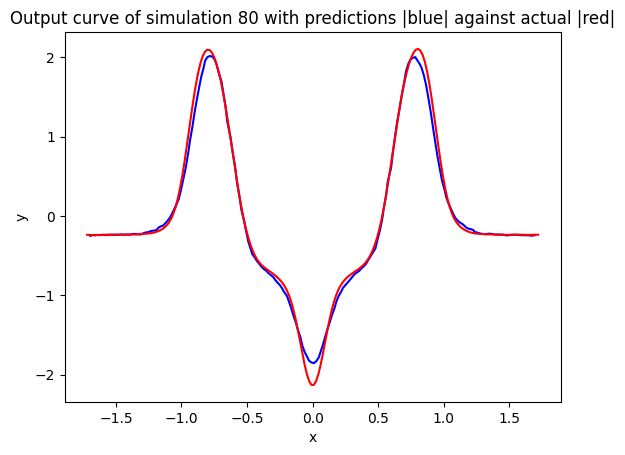

In [15]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(4000, activation="relu")(inputs)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(2000, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.20, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=250),
             TensorBoard(log_dir='model_5_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_14 (Dense)            (None, 4000)              4004000   
                                                                 
 dropout_12 (Dropout)        (None, 4000)              0         
                                                                 
 dense_15 (Dense)            (None, 2000)              8002000   
                                                                 
 dropout_13 (Dropout)        (None, 2000)              0         
                                                                 
 dense_16 (Dense)            (None, 2000)              4002000   
                                                                 
 dropout_14 (Dropout)        (None, 2000)              0   

7/7 [==============================] - 6s 1s/step - loss: 0.1426 - val_loss: 0.1565
Epoch 62/1500
7/7 [==============================] - 2s 361ms/step - loss: 0.1425 - val_loss: 0.1464
Epoch 63/1500
7/7 [==============================] - 2s 343ms/step - loss: 0.1445 - val_loss: 0.1559
Epoch 64/1500
7/7 [==============================] - 2s 360ms/step - loss: 0.1421 - val_loss: 0.1559
Epoch 65/1500
7/7 [==============================] - 2s 360ms/step - loss: 0.1415 - val_loss: 0.1484
Epoch 66/1500
7/7 [==============================] - 2s 362ms/step - loss: 0.1437 - val_loss: 0.1562
Epoch 67/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.1437 - val_loss: 0.1486
Epoch 68/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.1414 - val_loss: 0.1529
Epoch 69/1500
7/7 [==============================] - 2s 360ms/step - loss: 0.1410 - val_loss: 0.1558
Epoch 70/1500
7/7 [==============================] - 2s 347ms/step - loss: 0.1410 - val_loss: 0.1547
Epoch 7

Epoch 142/1500
7/7 [==============================] - 3s 488ms/step - loss: 0.1059 - val_loss: 0.1282
Epoch 143/1500
7/7 [==============================] - 2s 355ms/step - loss: 0.1047 - val_loss: 0.1294
Epoch 144/1500
7/7 [==============================] - 3s 425ms/step - loss: 0.1089 - val_loss: 0.1326
Epoch 145/1500
7/7 [==============================] - 2s 355ms/step - loss: 0.1091 - val_loss: 0.1339
Epoch 146/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.1091 - val_loss: 0.1310
Epoch 147/1500
7/7 [==============================] - 4s 552ms/step - loss: 0.1098 - val_loss: 0.1370
Epoch 148/1500
7/7 [==============================] - 3s 485ms/step - loss: 0.1092 - val_loss: 0.1329
Epoch 149/1500
7/7 [==============================] - 3s 527ms/step - loss: 0.1067 - val_loss: 0.1328
Epoch 150/1500
7/7 [==============================] - 3s 531ms/step - loss: 0.1047 - val_loss: 0.1339
Epoch 151/1500
7/7 [==============================] - 9s 1s/step - loss: 0.1047 - 

7/7 [==============================] - 3s 382ms/step - loss: 0.0787 - val_loss: 0.1073
Epoch 303/1500
7/7 [==============================] - 2s 354ms/step - loss: 0.0818 - val_loss: 0.1063
Epoch 304/1500
7/7 [==============================] - 2s 343ms/step - loss: 0.0831 - val_loss: 0.1071
Epoch 305/1500
7/7 [==============================] - 2s 362ms/step - loss: 0.0790 - val_loss: 0.1042
Epoch 306/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.0881 - val_loss: 0.1055
Epoch 307/1500
7/7 [==============================] - 2s 359ms/step - loss: 0.0866 - val_loss: 0.1051
Epoch 308/1500
7/7 [==============================] - 2s 342ms/step - loss: 0.0819 - val_loss: 0.1079
Epoch 309/1500
7/7 [==============================] - 2s 361ms/step - loss: 0.0822 - val_loss: 0.1050
Epoch 310/1500
7/7 [==============================] - 3s 366ms/step - loss: 0.0835 - val_loss: 0.1081
Epoch 311/1500
7/7 [==============================] - 6s 990ms/step - loss: 0.0816 - val_loss: 0.

7/7 [==============================] - 2s 355ms/step - loss: 0.0678 - val_loss: 0.0965
Epoch 463/1500
7/7 [==============================] - 2s 359ms/step - loss: 0.0678 - val_loss: 0.1031
Epoch 464/1500
7/7 [==============================] - 2s 352ms/step - loss: 0.0662 - val_loss: 0.1053
Epoch 465/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.0655 - val_loss: 0.1064
Epoch 466/1500
7/7 [==============================] - 2s 357ms/step - loss: 0.0654 - val_loss: 0.1022
Epoch 467/1500
7/7 [==============================] - 2s 359ms/step - loss: 0.0653 - val_loss: 0.1036
Epoch 468/1500
7/7 [==============================] - 3s 522ms/step - loss: 0.0656 - val_loss: 0.1043
Epoch 469/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.0655 - val_loss: 0.1090
Epoch 470/1500
7/7 [==============================] - 2s 354ms/step - loss: 0.0740 - val_loss: 0.1040
Epoch 471/1500
7/7 [==============================] - 6s 1s/step - loss: 0.0708 - val_loss: 0.097

7/7 [==============================] - 3s 425ms/step - loss: 0.0630 - val_loss: 0.0940
Epoch 623/1500
7/7 [==============================] - 3s 449ms/step - loss: 0.0604 - val_loss: 0.1016
Epoch 624/1500
7/7 [==============================] - 4s 597ms/step - loss: 0.0567 - val_loss: 0.1001
Epoch 625/1500
7/7 [==============================] - 4s 524ms/step - loss: 0.0593 - val_loss: 0.1046
Epoch 626/1500
7/7 [==============================] - 4s 633ms/step - loss: 0.0617 - val_loss: 0.1035
Epoch 627/1500
7/7 [==============================] - 3s 430ms/step - loss: 0.0618 - val_loss: 0.1042
Epoch 628/1500
7/7 [==============================] - 4s 609ms/step - loss: 0.0616 - val_loss: 0.1069
Epoch 629/1500
7/7 [==============================] - 4s 577ms/step - loss: 0.0637 - val_loss: 0.1076
Epoch 630/1500
7/7 [==============================] - 4s 598ms/step - loss: 0.0666 - val_loss: 0.1063
Epoch 631/1500
7/7 [==============================] - 11s 2s/step - loss: 0.0619 - val_loss: 0.10

7/7 [==============================] - 2s 360ms/step - loss: 0.0499 - val_loss: 0.0965
Epoch 783/1500
7/7 [==============================] - 2s 364ms/step - loss: 0.0493 - val_loss: 0.0984
Epoch 784/1500
7/7 [==============================] - 2s 362ms/step - loss: 0.0474 - val_loss: 0.0975
Epoch 785/1500
7/7 [==============================] - 2s 351ms/step - loss: 0.0464 - val_loss: 0.0948
Epoch 786/1500
7/7 [==============================] - 3s 385ms/step - loss: 0.0465 - val_loss: 0.1002
Epoch 787/1500
7/7 [==============================] - 3s 521ms/step - loss: 0.0487 - val_loss: 0.0953
Epoch 788/1500
7/7 [==============================] - 2s 358ms/step - loss: 0.0491 - val_loss: 0.0968
Epoch 789/1500
7/7 [==============================] - 2s 361ms/step - loss: 0.0485 - val_loss: 0.0961
Epoch 790/1500
7/7 [==============================] - 3s 396ms/step - loss: 0.0510 - val_loss: 0.0988
Epoch 791/1500
7/7 [==============================] - 6s 1s/step - loss: 0.0548 - val_loss: 0.094

7/7 [==============================] - 3s 423ms/step - loss: 0.0523 - val_loss: 0.0993
Epoch 943/1500
7/7 [==============================] - 3s 425ms/step - loss: 0.0498 - val_loss: 0.1074
Epoch 944/1500
7/7 [==============================] - 3s 425ms/step - loss: 0.0528 - val_loss: 0.1039
Epoch 945/1500
7/7 [==============================] - 3s 401ms/step - loss: 0.0487 - val_loss: 0.1000
Epoch 946/1500
7/7 [==============================] - 3s 441ms/step - loss: 0.0497 - val_loss: 0.0991
Epoch 947/1500
7/7 [==============================] - 3s 408ms/step - loss: 0.0460 - val_loss: 0.1029
Epoch 948/1500
7/7 [==============================] - 3s 409ms/step - loss: 0.0429 - val_loss: 0.1018
Epoch 949/1500
7/7 [==============================] - 3s 409ms/step - loss: 0.0434 - val_loss: 0.1004
Epoch 950/1500
7/7 [==============================] - 3s 409ms/step - loss: 0.0474 - val_loss: 0.1014
Epoch 951/1500
7/7 [==============================] - 7s 1s/step - loss: 0.0451 - val_loss: 0.099

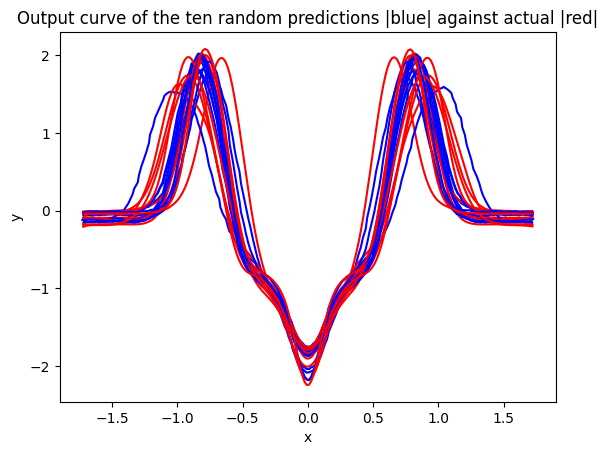

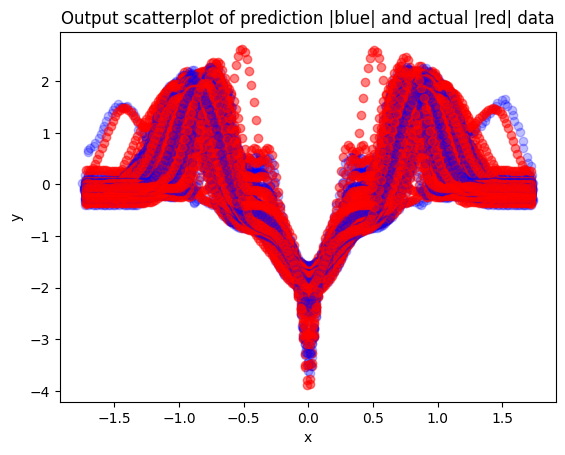

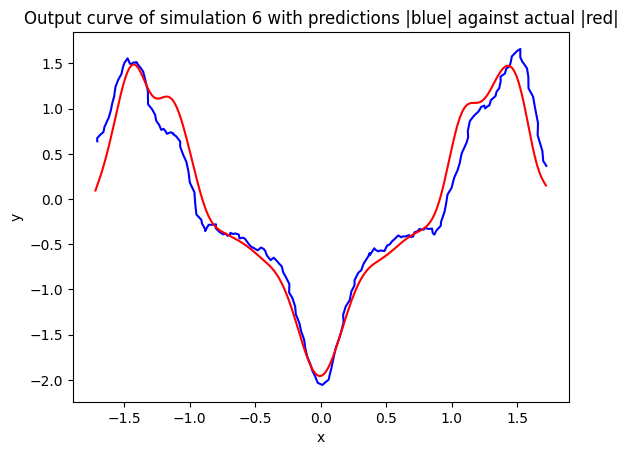

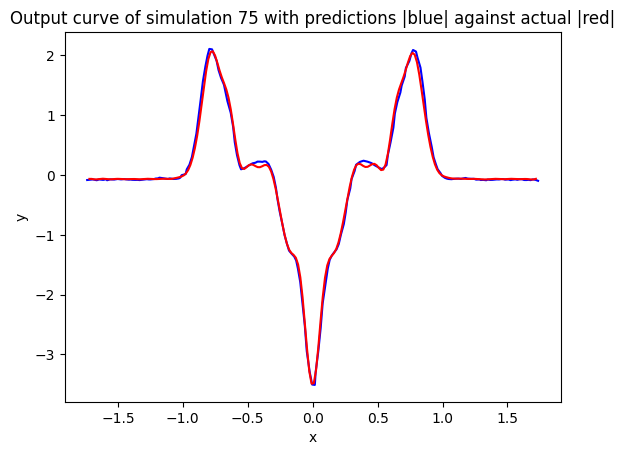

4/4 [==============================] - 0s 28ms/step


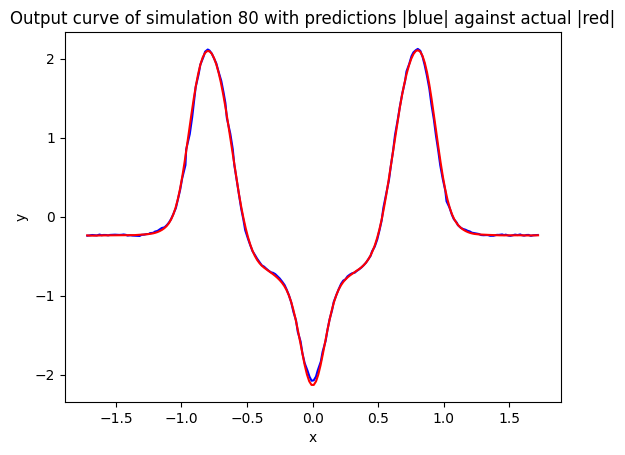

In [16]:
inputs = keras.Input(shape=(1000,))
x = layers.Dense(4000, activation="relu")(inputs)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu", bias_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu", bias_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu", bias_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(2000, activation="relu", bias_regularizer=l1(0.0001))(x)
x = layers.Dropout(0.10, seed=42)(x)
x = layers.Dense(1000, activation="relu", bias_regularizer=l1(0.0001))(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

callbacks = [EarlyStopping(monitor='val_loss', patience=250),
             TensorBoard(log_dir='model_5_data',
                         histogram_freq=10,
                         write_graph=False,
                         write_images=False,
                         update_freq='epoch',
                         embeddings_freq=0)]

model.fit(train_input_values, train_output_values, batch_size=61, epochs=1500, validation_split=0.2,callbacks=callbacks)
print('')
print('Loss is:' + str(loss(test_output_values, model.predict(test_input_values))))
print('')
plots(test_output_values,model.predict(test_input_values))